# FASE 1 - PREPROCESAMIENTO

### Gestión de dependencias: instalación y verificación de paquetes

In [2]:
import importlib
import subprocess

librerias_requeridas = ['numpy', 'matplotlib', 'scikit-learn', 'pandas', 'seaborn', 'tensorflow', 'keras','keras_nlp', 'autokeras', 'regex']

for lib in librerias_requeridas:
    try:
        importlib.import_module(lib)
        print(f'{lib} is already installed.')
    except ImportError:
        print(f'{lib} is not installed. Installing {lib}...')
        try:
            subprocess.check_call(['pip', 'install', lib])
            print(f'{lib} installed successfully.')
        except subprocess.CalledProcessError as e:
            print(f'Failed to install {lib}. Error: {e}')

# Rest of your code
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import autokeras as ak
import keras_nlp
from tensorflow.keras.models import load_model

import multiprocessing
from sklearn.model_selection import RepeatedKFold
import glob
import pandas as pd
import shutil
import pickle
import time
import datetime
import os
os.environ["OMP_NUM_THREADS"] = "32"

import seaborn as sns
sns.set_theme(style="whitegrid")


numpy is already installed.
matplotlib is already installed.
scikit-learn is not installed. Installing scikit-learn...
scikit-learn installed successfully.
pandas is already installed.
seaborn is already installed.
tensorflow is already installed.
keras is already installed.
keras_nlp is already installed.
autokeras is already installed.
regex is already installed.


### Funciones

In [3]:
def string2params(string, show=True):
    # Separamos la cadena en tres partes usando "g" y "v" como delimitadores
    s1 = string.partition("g")
    t = s1[0][1:] # Extraemos el valor de la temperatura a partir de la primera parte de la cadena
    s2 = s1[2].partition("v")
    g = s2[0] # Extraemos el valor de la gravedad superficial a partir de la segunda parte de la cadena
    v = s2[-1] # Extraemos el valor de la velocidad de rotación a partir de la tercera parte de la cadena
    if show: # Si show es True (verdadero), imprimimos los valores de la cadena extraídos
        print(s1)
        print("t:",t)
        print(s2)
        print("g: ",float(g)/10) # Convertimos el valor de la gravedad superficial de décimas de dex a unidades
        print("v:", v)
    return float(t), float(g)/10, float(v) # Devolvemos los valores de temperatura, gravedad superficial y velocidad de rotación en una tupla

### Listado de archivos

In [4]:
files = glob.glob('../filtered_wv_models/*')
m = len(files)
print("Número de archivos en modelos: ", m)

Número de archivos en modelos:  5425


### Matrices X e Y

In [5]:
# Imprimir dimensiones de X e y
print("--> X tiene dimensión", m, " x 201")
print("--> y tiene dimensión", m, " x 3")

# Inicializar y con ceros
y = np.zeros((m,3))

# Leer el primer archivo y obtener los puntos en el eje x
df = pd.read_csv(files[0], sep=" ", header=None)
x_points = df[0].values

# Obtener el número de puntos en el eje x
n_points, n_columns = df.shape
display(df[1].values.shape)
print("Número de puntos en eje x: ", n_points)

--> X tiene dimensión 5425  x 201
--> y tiene dimensión 5425  x 3


(201,)

Número de puntos en eje x:  201


In [6]:

# X matriz, contiene línea espectral
X = np.zeros((m,n_points))
# y matriz, contiene las etiquetas de cada línea espectral
y = np.zeros((m,3))

list_onda = []
list_flujo = []

    
for i,name in enumerate(files):
    file_name = name.split("/")[-1].split(".")[0]
    print(file_name)
    df = pd.read_csv(name, sep=" ", header=None)
    
    onda = df[0].values
    flujo = df[1].values
    
    list_onda.append(onda)
    list_flujo.append(flujo)
    
    print(file_name.split("_")[1])
    t,g,v = string2params(file_name.split("_")[1])
    X[i,:] = df[1].values
    y[i] = t,g,v


def plot_liness(list_onda, list_flujo):
    
    '''almacenará las ondas y flujos en listas. Luego, utiliza un loop for para trazar cada línea
    en el mismo gráfico utilizando la función zip para iterar sobre las dos listas al mismo tiempo'''
    
    plt.figure(figsize=(8, 5))
    plt.title("Líneas espectrales TLUSTLY")

    # lista para almacenar los valores promedio de flujo para cada valor de onda
    avg_flux = []

    for onda, flujo in zip(list_onda, list_flujo):
        plt.plot(onda, flujo)
        avg_flux.append(flujo)

    # Calcula la media de todos los valores de flujo para cada valor de onda
    avg_flux = np.mean(avg_flux, axis=0)
    
    # Agregar el ruido a la línea promedio
    #noise_avg = np.random.normal(mu*np.mean(avg_flux), sigma*np.std(avg_flux), len(avg_flux))
    #noisy_avg_flux = avg_flux + noise_avg

    # Grafica la línea media
    line_mean, = plt.plot(list_onda[0], avg_flux, color='b', linewidth=4)

    # Encuentra los valores máximos y mínimos de x e y de la línea media
    max_y = np.max(avg_flux)
    max_x = list_onda[0][np.argmax(avg_flux)]
    min_y = np.min(avg_flux)
    min_x = list_onda[0][np.argmin(avg_flux)]

    plt.xlabel("Longitud de Onda [A]")
    plt.ylabel("Flujo normalizado")
    plt.grid()

    # Agrega los valores máximos y mínimos a la leyenda
    plt.legend([line_mean], [f"Línea promedio (punto máximo en x={max_x:.2f}, y={max_y:.2f}; punto mínimo en x={min_x:.2f}, y={min_y:.2f})"], loc='lower left')
    plt.show()

f_t35000g40v100
t35000g40v100
('t35000', 'g', '40v100')
t: 35000
('40', 'v', '100')
g:  4.0
v: 100
f_t15000g30v270
t15000g30v270
('t15000', 'g', '30v270')
t: 15000
('30', 'v', '270')
g:  3.0
v: 270
f_t24000g20v220
t24000g20v220
('t24000', 'g', '20v220')
t: 24000
('20', 'v', '220')
g:  2.0
v: 220
f_t34000g35v380
t34000g35v380
('t34000', 'g', '35v380')
t: 34000
('35', 'v', '380')
g:  3.5
v: 380
f_t16000g45v140
t16000g45v140
('t16000', 'g', '45v140')
t: 16000
('45', 'v', '140')
g:  4.5
v: 140
f_t30000g30v240
t30000g30v240
('t30000', 'g', '30v240')
t: 30000
('30', 'v', '240')
g:  3.0
v: 240
f_t21000g35v140
t21000g35v140
('t21000', 'g', '35v140')
t: 21000
('35', 'v', '140')
g:  3.5
v: 140
f_t26000g30v310
t26000g30v310
('t26000', 'g', '30v310')
t: 26000
('30', 'v', '310')
g:  3.0
v: 310
f_t22000g25v330
t22000g25v330
('t22000', 'g', '25v330')
t: 22000
('25', 'v', '330')
g:  2.5
v: 330
f_t38000g35v260
t38000g35v260
('t38000', 'g', '35v260')
t: 38000
('35', 'v', '260')
g:  3.5
v: 260
f_t30000g3

t31000g30v280
('t31000', 'g', '30v280')
t: 31000
('30', 'v', '280')
g:  3.0
v: 280
f_t19000g40v370
t19000g40v370
('t19000', 'g', '40v370')
t: 19000
('40', 'v', '370')
g:  4.0
v: 370
f_t25000g40v250
t25000g40v250
('t25000', 'g', '40v250')
t: 25000
('40', 'v', '250')
g:  4.0
v: 250
f_t38000g40v370
t38000g40v370
('t38000', 'g', '40v370')
t: 38000
('40', 'v', '370')
g:  4.0
v: 370
f_t31000g30v300
t31000g30v300
('t31000', 'g', '30v300')
t: 31000
('30', 'v', '300')
g:  3.0
v: 300
f_t17000g20v320
t17000g20v320
('t17000', 'g', '20v320')
t: 17000
('20', 'v', '320')
g:  2.0
v: 320
f_t33000g30v290
t33000g30v290
('t33000', 'g', '30v290')
t: 33000
('30', 'v', '290')
g:  3.0
v: 290
f_t15000g35v170
t15000g35v170
('t15000', 'g', '35v170')
t: 15000
('35', 'v', '170')
g:  3.5
v: 170
f_t34000g40v240
t34000g40v240
('t34000', 'g', '40v240')
t: 34000
('40', 'v', '240')
g:  4.0
v: 240
f_t24000g35v140
t24000g35v140
('t24000', 'g', '35v140')
t: 24000
('35', 'v', '140')
g:  3.5
v: 140
f_t21000g25v210
t21000g25v

t34000g25v250
('t34000', 'g', '25v250')
t: 34000
('25', 'v', '250')
g:  2.5
v: 250
f_t15000g40v150
t15000g40v150
('t15000', 'g', '40v150')
t: 15000
('40', 'v', '150')
g:  4.0
v: 150
f_t26000g35v110
t26000g35v110
('t26000', 'g', '35v110')
t: 26000
('35', 'v', '110')
g:  3.5
v: 110
f_t27000g30v280
t27000g30v280
('t27000', 'g', '30v280')
t: 27000
('30', 'v', '280')
g:  3.0
v: 280
f_t24000g50v280
t24000g50v280
('t24000', 'g', '50v280')
t: 24000
('50', 'v', '280')
g:  5.0
v: 280
f_t37000g50v110
t37000g50v110
('t37000', 'g', '50v110')
t: 37000
('50', 'v', '110')
g:  5.0
v: 110
f_t26000g30v130
t26000g30v130
('t26000', 'g', '30v130')
t: 26000
('30', 'v', '130')
g:  3.0
v: 130
f_t29000g45v160
t29000g45v160
('t29000', 'g', '45v160')
t: 29000
('45', 'v', '160')
g:  4.5
v: 160
f_t33000g40v220
t33000g40v220
('t33000', 'g', '40v220')
t: 33000
('40', 'v', '220')
g:  4.0
v: 220
f_t19000g45v210
t19000g45v210
('t19000', 'g', '45v210')
t: 19000
('45', 'v', '210')
g:  4.5
v: 210
f_t31000g45v360
t31000g45v

t37000g45v110
('t37000', 'g', '45v110')
t: 37000
('45', 'v', '110')
g:  4.5
v: 110
f_t15000g40v310
t15000g40v310
('t15000', 'g', '40v310')
t: 15000
('40', 'v', '310')
g:  4.0
v: 310
f_t36000g30v310
t36000g30v310
('t36000', 'g', '30v310')
t: 36000
('30', 'v', '310')
g:  3.0
v: 310
f_t20000g30v110
t20000g30v110
('t20000', 'g', '30v110')
t: 20000
('30', 'v', '110')
g:  3.0
v: 110
f_t19000g50v370
t19000g50v370
('t19000', 'g', '50v370')
t: 19000
('50', 'v', '370')
g:  5.0
v: 370
f_t22000g20v100
t22000g20v100
('t22000', 'g', '20v100')
t: 22000
('20', 'v', '100')
g:  2.0
v: 100
f_t24000g20v320
t24000g20v320
('t24000', 'g', '20v320')
t: 24000
('20', 'v', '320')
g:  2.0
v: 320
f_t35000g35v230
t35000g35v230
('t35000', 'g', '35v230')
t: 35000
('35', 'v', '230')
g:  3.5
v: 230
f_t25000g40v140
t25000g40v140
('t25000', 'g', '40v140')
t: 25000
('40', 'v', '140')
g:  4.0
v: 140
f_t22000g50v250
t22000g50v250
('t22000', 'g', '50v250')
t: 22000
('50', 'v', '250')
g:  5.0
v: 250
f_t16000g35v280
t16000g35v

t25000g30v210
('t25000', 'g', '30v210')
t: 25000
('30', 'v', '210')
g:  3.0
v: 210
f_t39000g25v390
t39000g25v390
('t39000', 'g', '25v390')
t: 39000
('25', 'v', '390')
g:  2.5
v: 390
f_t19000g40v270
t19000g40v270
('t19000', 'g', '40v270')
t: 19000
('40', 'v', '270')
g:  4.0
v: 270
f_t20000g50v200
t20000g50v200
('t20000', 'g', '50v200')
t: 20000
('50', 'v', '200')
g:  5.0
v: 200
f_t35000g35v300
t35000g35v300
('t35000', 'g', '35v300')
t: 35000
('35', 'v', '300')
g:  3.5
v: 300
f_t38000g25v190
t38000g25v190
('t38000', 'g', '25v190')
t: 38000
('25', 'v', '190')
g:  2.5
v: 190
f_t34000g25v110
t34000g25v110
('t34000', 'g', '25v110')
t: 34000
('25', 'v', '110')
g:  2.5
v: 110
f_t28000g25v180
t28000g25v180
('t28000', 'g', '25v180')
t: 28000
('25', 'v', '180')
g:  2.5
v: 180
f_t15000g30v250
t15000g30v250
('t15000', 'g', '30v250')
t: 15000
('30', 'v', '250')
g:  3.0
v: 250
f_t24000g25v100
t24000g25v100
('t24000', 'g', '25v100')
t: 24000
('25', 'v', '100')
g:  2.5
v: 100
f_t34000g40v250
t34000g40v

t26000g20v270
('t26000', 'g', '20v270')
t: 26000
('20', 'v', '270')
g:  2.0
v: 270
f_t15000g25v250
t15000g25v250
('t15000', 'g', '25v250')
t: 15000
('25', 'v', '250')
g:  2.5
v: 250
f_t20000g50v190
t20000g50v190
('t20000', 'g', '50v190')
t: 20000
('50', 'v', '190')
g:  5.0
v: 190
f_t18000g40v350
t18000g40v350
('t18000', 'g', '40v350')
t: 18000
('40', 'v', '350')
g:  4.0
v: 350
f_t24000g20v370
t24000g20v370
('t24000', 'g', '20v370')
t: 24000
('20', 'v', '370')
g:  2.0
v: 370
f_t16000g25v170
t16000g25v170
('t16000', 'g', '25v170')
t: 16000
('25', 'v', '170')
g:  2.5
v: 170
f_t29000g45v360
t29000g45v360
('t29000', 'g', '45v360')
t: 29000
('45', 'v', '360')
g:  4.5
v: 360
f_t36000g25v350
t36000g25v350
('t36000', 'g', '25v350')
t: 36000
('25', 'v', '350')
g:  2.5
v: 350
f_t38000g20v160
t38000g20v160
('t38000', 'g', '20v160')
t: 38000
('20', 'v', '160')
g:  2.0
v: 160
f_t19000g20v110
t19000g20v110
('t19000', 'g', '20v110')
t: 19000
('20', 'v', '110')
g:  2.0
v: 110
f_t26000g25v340
t26000g25v

t32000g45v110
('t32000', 'g', '45v110')
t: 32000
('45', 'v', '110')
g:  4.5
v: 110
f_t37000g45v120
t37000g45v120
('t37000', 'g', '45v120')
t: 37000
('45', 'v', '120')
g:  4.5
v: 120
f_t20000g45v370
t20000g45v370
('t20000', 'g', '45v370')
t: 20000
('45', 'v', '370')
g:  4.5
v: 370
f_t21000g40v240
t21000g40v240
('t21000', 'g', '40v240')
t: 21000
('40', 'v', '240')
g:  4.0
v: 240
f_t21000g30v320
t21000g30v320
('t21000', 'g', '30v320')
t: 21000
('30', 'v', '320')
g:  3.0
v: 320
f_t36000g25v220
t36000g25v220
('t36000', 'g', '25v220')
t: 36000
('25', 'v', '220')
g:  2.5
v: 220
f_t17000g20v270
t17000g20v270
('t17000', 'g', '20v270')
t: 17000
('20', 'v', '270')
g:  2.0
v: 270
f_t27000g40v350
t27000g40v350
('t27000', 'g', '40v350')
t: 27000
('40', 'v', '350')
g:  4.0
v: 350
f_t22000g40v350
t22000g40v350
('t22000', 'g', '40v350')
t: 22000
('40', 'v', '350')
g:  4.0
v: 350
f_t39000g30v120
t39000g30v120
('t39000', 'g', '30v120')
t: 39000
('30', 'v', '120')
g:  3.0
v: 120
f_t32000g40v190
t32000g40v

t27000g20v220
('t27000', 'g', '20v220')
t: 27000
('20', 'v', '220')
g:  2.0
v: 220
f_t38000g35v310
t38000g35v310
('t38000', 'g', '35v310')
t: 38000
('35', 'v', '310')
g:  3.5
v: 310
f_t15000g40v360
t15000g40v360
('t15000', 'g', '40v360')
t: 15000
('40', 'v', '360')
g:  4.0
v: 360
f_t34000g20v300
t34000g20v300
('t34000', 'g', '20v300')
t: 34000
('20', 'v', '300')
g:  2.0
v: 300
f_t32000g25v150
t32000g25v150
('t32000', 'g', '25v150')
t: 32000
('25', 'v', '150')
g:  2.5
v: 150
f_t30000g35v360
t30000g35v360
('t30000', 'g', '35v360')
t: 30000
('35', 'v', '360')
g:  3.5
v: 360
f_t29000g25v390
t29000g25v390
('t29000', 'g', '25v390')
t: 29000
('25', 'v', '390')
g:  2.5
v: 390
f_t15000g25v160
t15000g25v160
('t15000', 'g', '25v160')
t: 15000
('25', 'v', '160')
g:  2.5
v: 160
f_t21000g35v290
t21000g35v290
('t21000', 'g', '35v290')
t: 21000
('35', 'v', '290')
g:  3.5
v: 290
f_t28000g45v250
t28000g45v250
('t28000', 'g', '45v250')
t: 28000
('45', 'v', '250')
g:  4.5
v: 250
f_t32000g20v380
t32000g20v

t32000g35v110
('t32000', 'g', '35v110')
t: 32000
('35', 'v', '110')
g:  3.5
v: 110
f_t21000g35v120
t21000g35v120
('t21000', 'g', '35v120')
t: 21000
('35', 'v', '120')
g:  3.5
v: 120
f_t30000g35v110
t30000g35v110
('t30000', 'g', '35v110')
t: 30000
('35', 'v', '110')
g:  3.5
v: 110
f_t23000g45v370
t23000g45v370
('t23000', 'g', '45v370')
t: 23000
('45', 'v', '370')
g:  4.5
v: 370
f_t27000g40v300
t27000g40v300
('t27000', 'g', '40v300')
t: 27000
('40', 'v', '300')
g:  4.0
v: 300
f_t31000g45v210
t31000g45v210
('t31000', 'g', '45v210')
t: 31000
('45', 'v', '210')
g:  4.5
v: 210
f_t30000g50v310
t30000g50v310
('t30000', 'g', '50v310')
t: 30000
('50', 'v', '310')
g:  5.0
v: 310
f_t28000g30v220
t28000g30v220
('t28000', 'g', '30v220')
t: 28000
('30', 'v', '220')
g:  3.0
v: 220
f_t18000g20v180
t18000g20v180
('t18000', 'g', '20v180')
t: 18000
('20', 'v', '180')
g:  2.0
v: 180
f_t37000g25v320
t37000g25v320
('t37000', 'g', '25v320')
t: 37000
('25', 'v', '320')
g:  2.5
v: 320
f_t32000g35v170
t32000g35v

t22000g20v250
('t22000', 'g', '20v250')
t: 22000
('20', 'v', '250')
g:  2.0
v: 250
f_t36000g40v190
t36000g40v190
('t36000', 'g', '40v190')
t: 36000
('40', 'v', '190')
g:  4.0
v: 190
f_t29000g25v140
t29000g25v140
('t29000', 'g', '25v140')
t: 29000
('25', 'v', '140')
g:  2.5
v: 140
f_t34000g35v220
t34000g35v220
('t34000', 'g', '35v220')
t: 34000
('35', 'v', '220')
g:  3.5
v: 220
f_t25000g40v320
t25000g40v320
('t25000', 'g', '40v320')
t: 25000
('40', 'v', '320')
g:  4.0
v: 320
f_t29000g40v300
t29000g40v300
('t29000', 'g', '40v300')
t: 29000
('40', 'v', '300')
g:  4.0
v: 300
f_t35000g25v120
t35000g25v120
('t35000', 'g', '25v120')
t: 35000
('25', 'v', '120')
g:  2.5
v: 120
f_t19000g40v380
t19000g40v380
('t19000', 'g', '40v380')
t: 19000
('40', 'v', '380')
g:  4.0
v: 380
f_t33000g20v340
t33000g20v340
('t33000', 'g', '20v340')
t: 33000
('20', 'v', '340')
g:  2.0
v: 340
f_t21000g40v280
t21000g40v280
('t21000', 'g', '40v280')
t: 21000
('40', 'v', '280')
g:  4.0
v: 280
f_t39000g35v160
t39000g35v

t32000g35v320
('t32000', 'g', '35v320')
t: 32000
('35', 'v', '320')
g:  3.5
v: 320
f_t18000g40v140
t18000g40v140
('t18000', 'g', '40v140')
t: 18000
('40', 'v', '140')
g:  4.0
v: 140
f_t37000g40v310
t37000g40v310
('t37000', 'g', '40v310')
t: 37000
('40', 'v', '310')
g:  4.0
v: 310
f_t37000g20v400
t37000g20v400
('t37000', 'g', '20v400')
t: 37000
('20', 'v', '400')
g:  2.0
v: 400
f_t38000g50v200
t38000g50v200
('t38000', 'g', '50v200')
t: 38000
('50', 'v', '200')
g:  5.0
v: 200
f_t27000g35v200
t27000g35v200
('t27000', 'g', '35v200')
t: 27000
('35', 'v', '200')
g:  3.5
v: 200
f_t22000g35v100
t22000g35v100
('t22000', 'g', '35v100')
t: 22000
('35', 'v', '100')
g:  3.5
v: 100
f_t33000g30v400
t33000g30v400
('t33000', 'g', '30v400')
t: 33000
('30', 'v', '400')
g:  3.0
v: 400
f_t39000g50v330
t39000g50v330
('t39000', 'g', '50v330')
t: 39000
('50', 'v', '330')
g:  5.0
v: 330
f_t33000g25v140
t33000g25v140
('t33000', 'g', '25v140')
t: 33000
('25', 'v', '140')
g:  2.5
v: 140
f_t37000g25v310
t37000g25v

t20000g40v340
('t20000', 'g', '40v340')
t: 20000
('40', 'v', '340')
g:  4.0
v: 340
f_t29000g50v280
t29000g50v280
('t29000', 'g', '50v280')
t: 29000
('50', 'v', '280')
g:  5.0
v: 280
f_t23000g40v320
t23000g40v320
('t23000', 'g', '40v320')
t: 23000
('40', 'v', '320')
g:  4.0
v: 320
f_t35000g20v230
t35000g20v230
('t35000', 'g', '20v230')
t: 35000
('20', 'v', '230')
g:  2.0
v: 230
f_t32000g40v320
t32000g40v320
('t32000', 'g', '40v320')
t: 32000
('40', 'v', '320')
g:  4.0
v: 320
f_t16000g50v230
t16000g50v230
('t16000', 'g', '50v230')
t: 16000
('50', 'v', '230')
g:  5.0
v: 230
f_t37000g25v360
t37000g25v360
('t37000', 'g', '25v360')
t: 37000
('25', 'v', '360')
g:  2.5
v: 360
f_t30000g25v190
t30000g25v190
('t30000', 'g', '25v190')
t: 30000
('25', 'v', '190')
g:  2.5
v: 190
f_t16000g30v400
t16000g30v400
('t16000', 'g', '30v400')
t: 16000
('30', 'v', '400')
g:  3.0
v: 400
f_t18000g30v320
t18000g30v320
('t18000', 'g', '30v320')
t: 18000
('30', 'v', '320')
g:  3.0
v: 320
f_t18000g35v120
t18000g35v

t23000g25v370
('t23000', 'g', '25v370')
t: 23000
('25', 'v', '370')
g:  2.5
v: 370
f_t26000g25v370
t26000g25v370
('t26000', 'g', '25v370')
t: 26000
('25', 'v', '370')
g:  2.5
v: 370
f_t28000g40v140
t28000g40v140
('t28000', 'g', '40v140')
t: 28000
('40', 'v', '140')
g:  4.0
v: 140
f_t35000g40v250
t35000g40v250
('t35000', 'g', '40v250')
t: 35000
('40', 'v', '250')
g:  4.0
v: 250
f_t22000g45v140
t22000g45v140
('t22000', 'g', '45v140')
t: 22000
('45', 'v', '140')
g:  4.5
v: 140
f_t15000g25v340
t15000g25v340
('t15000', 'g', '25v340')
t: 15000
('25', 'v', '340')
g:  2.5
v: 340
f_t17000g45v180
t17000g45v180
('t17000', 'g', '45v180')
t: 17000
('45', 'v', '180')
g:  4.5
v: 180
f_t16000g30v150
t16000g30v150
('t16000', 'g', '30v150')
t: 16000
('30', 'v', '150')
g:  3.0
v: 150
f_t30000g35v230
t30000g35v230
('t30000', 'g', '35v230')
t: 30000
('35', 'v', '230')
g:  3.5
v: 230
f_t20000g35v100
t20000g35v100
('t20000', 'g', '35v100')
t: 20000
('35', 'v', '100')
g:  3.5
v: 100
f_t20000g40v290
t20000g40v

t28000g50v150
('t28000', 'g', '50v150')
t: 28000
('50', 'v', '150')
g:  5.0
v: 150
f_t25000g20v390
t25000g20v390
('t25000', 'g', '20v390')
t: 25000
('20', 'v', '390')
g:  2.0
v: 390
f_t39000g45v180
t39000g45v180
('t39000', 'g', '45v180')
t: 39000
('45', 'v', '180')
g:  4.5
v: 180
f_t20000g30v340
t20000g30v340
('t20000', 'g', '30v340')
t: 20000
('30', 'v', '340')
g:  3.0
v: 340
f_t27000g40v220
t27000g40v220
('t27000', 'g', '40v220')
t: 27000
('40', 'v', '220')
g:  4.0
v: 220
f_t21000g40v360
t21000g40v360
('t21000', 'g', '40v360')
t: 21000
('40', 'v', '360')
g:  4.0
v: 360
f_t21000g50v150
t21000g50v150
('t21000', 'g', '50v150')
t: 21000
('50', 'v', '150')
g:  5.0
v: 150
f_t35000g20v370
t35000g20v370
('t35000', 'g', '20v370')
t: 35000
('20', 'v', '370')
g:  2.0
v: 370
f_t36000g25v400
t36000g25v400
('t36000', 'g', '25v400')
t: 36000
('25', 'v', '400')
g:  2.5
v: 400
f_t34000g50v360
t34000g50v360
('t34000', 'g', '50v360')
t: 34000
('50', 'v', '360')
g:  5.0
v: 360
f_t28000g35v120
t28000g35v

t39000g30v160
('t39000', 'g', '30v160')
t: 39000
('30', 'v', '160')
g:  3.0
v: 160
f_t28000g30v390
t28000g30v390
('t28000', 'g', '30v390')
t: 28000
('30', 'v', '390')
g:  3.0
v: 390
f_t22000g25v290
t22000g25v290
('t22000', 'g', '25v290')
t: 22000
('25', 'v', '290')
g:  2.5
v: 290
f_t18000g35v270
t18000g35v270
('t18000', 'g', '35v270')
t: 18000
('35', 'v', '270')
g:  3.5
v: 270
f_t29000g40v190
t29000g40v190
('t29000', 'g', '40v190')
t: 29000
('40', 'v', '190')
g:  4.0
v: 190
f_t25000g50v270
t25000g50v270
('t25000', 'g', '50v270')
t: 25000
('50', 'v', '270')
g:  5.0
v: 270
f_t22000g45v240
t22000g45v240
('t22000', 'g', '45v240')
t: 22000
('45', 'v', '240')
g:  4.5
v: 240
f_t16000g45v230
t16000g45v230
('t16000', 'g', '45v230')
t: 16000
('45', 'v', '230')
g:  4.5
v: 230
f_t27000g40v190
t27000g40v190
('t27000', 'g', '40v190')
t: 27000
('40', 'v', '190')
g:  4.0
v: 190
f_t32000g50v220
t32000g50v220
('t32000', 'g', '50v220')
t: 32000
('50', 'v', '220')
g:  5.0
v: 220
f_t35000g40v110
t35000g40v

t37000g20v180
('t37000', 'g', '20v180')
t: 37000
('20', 'v', '180')
g:  2.0
v: 180
f_t28000g25v240
t28000g25v240
('t28000', 'g', '25v240')
t: 28000
('25', 'v', '240')
g:  2.5
v: 240
f_t34000g50v380
t34000g50v380
('t34000', 'g', '50v380')
t: 34000
('50', 'v', '380')
g:  5.0
v: 380
f_t32000g35v240
t32000g35v240
('t32000', 'g', '35v240')
t: 32000
('35', 'v', '240')
g:  3.5
v: 240
f_t19000g25v150
t19000g25v150
('t19000', 'g', '25v150')
t: 19000
('25', 'v', '150')
g:  2.5
v: 150
f_t16000g20v210
t16000g20v210
('t16000', 'g', '20v210')
t: 16000
('20', 'v', '210')
g:  2.0
v: 210
f_t17000g50v150
t17000g50v150
('t17000', 'g', '50v150')
t: 17000
('50', 'v', '150')
g:  5.0
v: 150
f_t25000g30v370
t25000g30v370
('t25000', 'g', '30v370')
t: 25000
('30', 'v', '370')
g:  3.0
v: 370
f_t30000g50v180
t30000g50v180
('t30000', 'g', '50v180')
t: 30000
('50', 'v', '180')
g:  5.0
v: 180
f_t33000g30v170
t33000g30v170
('t33000', 'g', '30v170')
t: 33000
('30', 'v', '170')
g:  3.0
v: 170
f_t26000g35v190
t26000g35v

t31000g40v270
('t31000', 'g', '40v270')
t: 31000
('40', 'v', '270')
g:  4.0
v: 270
f_t15000g45v110
t15000g45v110
('t15000', 'g', '45v110')
t: 15000
('45', 'v', '110')
g:  4.5
v: 110
f_t25000g20v270
t25000g20v270
('t25000', 'g', '20v270')
t: 25000
('20', 'v', '270')
g:  2.0
v: 270
f_t17000g20v330
t17000g20v330
('t17000', 'g', '20v330')
t: 17000
('20', 'v', '330')
g:  2.0
v: 330
f_t35000g50v230
t35000g50v230
('t35000', 'g', '50v230')
t: 35000
('50', 'v', '230')
g:  5.0
v: 230
f_t29000g45v230
t29000g45v230
('t29000', 'g', '45v230')
t: 29000
('45', 'v', '230')
g:  4.5
v: 230
f_t23000g45v340
t23000g45v340
('t23000', 'g', '45v340')
t: 23000
('45', 'v', '340')
g:  4.5
v: 340
f_t20000g25v230
t20000g25v230
('t20000', 'g', '25v230')
t: 20000
('25', 'v', '230')
g:  2.5
v: 230
f_t35000g35v240
t35000g35v240
('t35000', 'g', '35v240')
t: 35000
('35', 'v', '240')
g:  3.5
v: 240
f_t21000g30v390
t21000g30v390
('t21000', 'g', '30v390')
t: 21000
('30', 'v', '390')
g:  3.0
v: 390
f_t22000g25v360
t22000g25v

t38000g30v120
('t38000', 'g', '30v120')
t: 38000
('30', 'v', '120')
g:  3.0
v: 120
f_t24000g20v260
t24000g20v260
('t24000', 'g', '20v260')
t: 24000
('20', 'v', '260')
g:  2.0
v: 260
f_t28000g20v400
t28000g20v400
('t28000', 'g', '20v400')
t: 28000
('20', 'v', '400')
g:  2.0
v: 400
f_t26000g45v110
t26000g45v110
('t26000', 'g', '45v110')
t: 26000
('45', 'v', '110')
g:  4.5
v: 110
f_t35000g20v250
t35000g20v250
('t35000', 'g', '20v250')
t: 35000
('20', 'v', '250')
g:  2.0
v: 250
f_t25000g30v380
t25000g30v380
('t25000', 'g', '30v380')
t: 25000
('30', 'v', '380')
g:  3.0
v: 380
f_t30000g50v300
t30000g50v300
('t30000', 'g', '50v300')
t: 30000
('50', 'v', '300')
g:  5.0
v: 300
f_t36000g20v360
t36000g20v360
('t36000', 'g', '20v360')
t: 36000
('20', 'v', '360')
g:  2.0
v: 360
f_t29000g35v230
t29000g35v230
('t29000', 'g', '35v230')
t: 29000
('35', 'v', '230')
g:  3.5
v: 230
f_t24000g25v390
t24000g25v390
('t24000', 'g', '25v390')
t: 24000
('25', 'v', '390')
g:  2.5
v: 390
f_t26000g45v300
t26000g45v

t26000g30v260
('t26000', 'g', '30v260')
t: 26000
('30', 'v', '260')
g:  3.0
v: 260
f_t15000g40v300
t15000g40v300
('t15000', 'g', '40v300')
t: 15000
('40', 'v', '300')
g:  4.0
v: 300
f_t33000g30v370
t33000g30v370
('t33000', 'g', '30v370')
t: 33000
('30', 'v', '370')
g:  3.0
v: 370
f_t32000g30v330
t32000g30v330
('t32000', 'g', '30v330')
t: 32000
('30', 'v', '330')
g:  3.0
v: 330
f_t33000g50v150
t33000g50v150
('t33000', 'g', '50v150')
t: 33000
('50', 'v', '150')
g:  5.0
v: 150
f_t16000g20v230
t16000g20v230
('t16000', 'g', '20v230')
t: 16000
('20', 'v', '230')
g:  2.0
v: 230
f_t39000g30v240
t39000g30v240
('t39000', 'g', '30v240')
t: 39000
('30', 'v', '240')
g:  3.0
v: 240
f_t22000g25v320
t22000g25v320
('t22000', 'g', '25v320')
t: 22000
('25', 'v', '320')
g:  2.5
v: 320
f_t29000g40v280
t29000g40v280
('t29000', 'g', '40v280')
t: 29000
('40', 'v', '280')
g:  4.0
v: 280
f_t20000g30v190
t20000g30v190
('t20000', 'g', '30v190')
t: 20000
('30', 'v', '190')
g:  3.0
v: 190
f_t30000g40v310
t30000g40v

t26000g30v120
('t26000', 'g', '30v120')
t: 26000
('30', 'v', '120')
g:  3.0
v: 120
f_t39000g35v290
t39000g35v290
('t39000', 'g', '35v290')
t: 39000
('35', 'v', '290')
g:  3.5
v: 290
f_t35000g25v140
t35000g25v140
('t35000', 'g', '25v140')
t: 35000
('25', 'v', '140')
g:  2.5
v: 140
f_t25000g30v200
t25000g30v200
('t25000', 'g', '30v200')
t: 25000
('30', 'v', '200')
g:  3.0
v: 200
f_t27000g50v120
t27000g50v120
('t27000', 'g', '50v120')
t: 27000
('50', 'v', '120')
g:  5.0
v: 120
f_t30000g50v230
t30000g50v230
('t30000', 'g', '50v230')
t: 30000
('50', 'v', '230')
g:  5.0
v: 230
f_t31000g40v300
t31000g40v300
('t31000', 'g', '40v300')
t: 31000
('40', 'v', '300')
g:  4.0
v: 300
f_t37000g25v110
t37000g25v110
('t37000', 'g', '25v110')
t: 37000
('25', 'v', '110')
g:  2.5
v: 110
f_t16000g40v180
t16000g40v180
('t16000', 'g', '40v180')
t: 16000
('40', 'v', '180')
g:  4.0
v: 180
f_t27000g50v170
t27000g50v170
('t27000', 'g', '50v170')
t: 27000
('50', 'v', '170')
g:  5.0
v: 170
f_t16000g30v190
t16000g30v

t23000g30v100
('t23000', 'g', '30v100')
t: 23000
('30', 'v', '100')
g:  3.0
v: 100
f_t18000g35v290
t18000g35v290
('t18000', 'g', '35v290')
t: 18000
('35', 'v', '290')
g:  3.5
v: 290
f_t17000g45v210
t17000g45v210
('t17000', 'g', '45v210')
t: 17000
('45', 'v', '210')
g:  4.5
v: 210
f_t30000g50v370
t30000g50v370
('t30000', 'g', '50v370')
t: 30000
('50', 'v', '370')
g:  5.0
v: 370
f_t30000g50v290
t30000g50v290
('t30000', 'g', '50v290')
t: 30000
('50', 'v', '290')
g:  5.0
v: 290
f_t34000g45v380
t34000g45v380
('t34000', 'g', '45v380')
t: 34000
('45', 'v', '380')
g:  4.5
v: 380
f_t19000g35v280
t19000g35v280
('t19000', 'g', '35v280')
t: 19000
('35', 'v', '280')
g:  3.5
v: 280
f_t37000g35v160
t37000g35v160
('t37000', 'g', '35v160')
t: 37000
('35', 'v', '160')
g:  3.5
v: 160
f_t35000g35v100
t35000g35v100
('t35000', 'g', '35v100')
t: 35000
('35', 'v', '100')
g:  3.5
v: 100
f_t28000g40v390
t28000g40v390
('t28000', 'g', '40v390')
t: 28000
('40', 'v', '390')
g:  4.0
v: 390
f_t38000g40v120
t38000g40v

t37000g30v270
('t37000', 'g', '30v270')
t: 37000
('30', 'v', '270')
g:  3.0
v: 270
f_t34000g30v230
t34000g30v230
('t34000', 'g', '30v230')
t: 34000
('30', 'v', '230')
g:  3.0
v: 230
f_t39000g35v210
t39000g35v210
('t39000', 'g', '35v210')
t: 39000
('35', 'v', '210')
g:  3.5
v: 210
f_t29000g25v320
t29000g25v320
('t29000', 'g', '25v320')
t: 29000
('25', 'v', '320')
g:  2.5
v: 320
f_t37000g50v400
t37000g50v400
('t37000', 'g', '50v400')
t: 37000
('50', 'v', '400')
g:  5.0
v: 400
f_t29000g45v250
t29000g45v250
('t29000', 'g', '45v250')
t: 29000
('45', 'v', '250')
g:  4.5
v: 250
f_t25000g40v330
t25000g40v330
('t25000', 'g', '40v330')
t: 25000
('40', 'v', '330')
g:  4.0
v: 330
f_t16000g40v330
t16000g40v330
('t16000', 'g', '40v330')
t: 16000
('40', 'v', '330')
g:  4.0
v: 330
f_t17000g45v200
t17000g45v200
('t17000', 'g', '45v200')
t: 17000
('45', 'v', '200')
g:  4.5
v: 200
f_t22000g40v260
t22000g40v260
('t22000', 'g', '40v260')
t: 22000
('40', 'v', '260')
g:  4.0
v: 260
f_t35000g40v120
t35000g40v

t30000g40v110
('t30000', 'g', '40v110')
t: 30000
('40', 'v', '110')
g:  4.0
v: 110
f_t38000g45v160
t38000g45v160
('t38000', 'g', '45v160')
t: 38000
('45', 'v', '160')
g:  4.5
v: 160
f_t21000g45v100
t21000g45v100
('t21000', 'g', '45v100')
t: 21000
('45', 'v', '100')
g:  4.5
v: 100
f_t30000g20v190
t30000g20v190
('t30000', 'g', '20v190')
t: 30000
('20', 'v', '190')
g:  2.0
v: 190
f_t28000g20v100
t28000g20v100
('t28000', 'g', '20v100')
t: 28000
('20', 'v', '100')
g:  2.0
v: 100
f_t30000g50v220
t30000g50v220
('t30000', 'g', '50v220')
t: 30000
('50', 'v', '220')
g:  5.0
v: 220
f_t39000g50v100
t39000g50v100
('t39000', 'g', '50v100')
t: 39000
('50', 'v', '100')
g:  5.0
v: 100
f_t15000g30v320
t15000g30v320
('t15000', 'g', '30v320')
t: 15000
('30', 'v', '320')
g:  3.0
v: 320
f_t15000g50v340
t15000g50v340
('t15000', 'g', '50v340')
t: 15000
('50', 'v', '340')
g:  5.0
v: 340
f_t31000g50v380
t31000g50v380
('t31000', 'g', '50v380')
t: 31000
('50', 'v', '380')
g:  5.0
v: 380
f_t23000g20v350
t23000g20v

t29000g40v310
('t29000', 'g', '40v310')
t: 29000
('40', 'v', '310')
g:  4.0
v: 310
f_t24000g30v200
t24000g30v200
('t24000', 'g', '30v200')
t: 24000
('30', 'v', '200')
g:  3.0
v: 200
f_t16000g30v200
t16000g30v200
('t16000', 'g', '30v200')
t: 16000
('30', 'v', '200')
g:  3.0
v: 200
f_t15000g20v150
t15000g20v150
('t15000', 'g', '20v150')
t: 15000
('20', 'v', '150')
g:  2.0
v: 150
f_t32000g20v200
t32000g20v200
('t32000', 'g', '20v200')
t: 32000
('20', 'v', '200')
g:  2.0
v: 200
f_t35000g30v370
t35000g30v370
('t35000', 'g', '30v370')
t: 35000
('30', 'v', '370')
g:  3.0
v: 370
f_t24000g30v370
t24000g30v370
('t24000', 'g', '30v370')
t: 24000
('30', 'v', '370')
g:  3.0
v: 370
f_t24000g25v280
t24000g25v280
('t24000', 'g', '25v280')
t: 24000
('25', 'v', '280')
g:  2.5
v: 280
f_t25000g40v220
t25000g40v220
('t25000', 'g', '40v220')
t: 25000
('40', 'v', '220')
g:  4.0
v: 220
f_t25000g50v340
t25000g50v340
('t25000', 'g', '50v340')
t: 25000
('50', 'v', '340')
g:  5.0
v: 340
f_t35000g45v240
t35000g45v

t26000g50v360
('t26000', 'g', '50v360')
t: 26000
('50', 'v', '360')
g:  5.0
v: 360
f_t33000g40v290
t33000g40v290
('t33000', 'g', '40v290')
t: 33000
('40', 'v', '290')
g:  4.0
v: 290
f_t20000g20v340
t20000g20v340
('t20000', 'g', '20v340')
t: 20000
('20', 'v', '340')
g:  2.0
v: 340
f_t23000g20v190
t23000g20v190
('t23000', 'g', '20v190')
t: 23000
('20', 'v', '190')
g:  2.0
v: 190
f_t20000g20v270
t20000g20v270
('t20000', 'g', '20v270')
t: 20000
('20', 'v', '270')
g:  2.0
v: 270
f_t36000g20v130
t36000g20v130
('t36000', 'g', '20v130')
t: 36000
('20', 'v', '130')
g:  2.0
v: 130
f_t16000g50v360
t16000g50v360
('t16000', 'g', '50v360')
t: 16000
('50', 'v', '360')
g:  5.0
v: 360
f_t25000g45v190
t25000g45v190
('t25000', 'g', '45v190')
t: 25000
('45', 'v', '190')
g:  4.5
v: 190
f_t30000g45v140
t30000g45v140
('t30000', 'g', '45v140')
t: 30000
('45', 'v', '140')
g:  4.5
v: 140
f_t16000g35v170
t16000g35v170
('t16000', 'g', '35v170')
t: 16000
('35', 'v', '170')
g:  3.5
v: 170
f_t38000g30v230
t38000g30v

t24000g45v230
('t24000', 'g', '45v230')
t: 24000
('45', 'v', '230')
g:  4.5
v: 230
f_t36000g45v270
t36000g45v270
('t36000', 'g', '45v270')
t: 36000
('45', 'v', '270')
g:  4.5
v: 270
f_t23000g25v190
t23000g25v190
('t23000', 'g', '25v190')
t: 23000
('25', 'v', '190')
g:  2.5
v: 190
f_t38000g45v150
t38000g45v150
('t38000', 'g', '45v150')
t: 38000
('45', 'v', '150')
g:  4.5
v: 150
f_t39000g20v200
t39000g20v200
('t39000', 'g', '20v200')
t: 39000
('20', 'v', '200')
g:  2.0
v: 200
f_t39000g20v350
t39000g20v350
('t39000', 'g', '20v350')
t: 39000
('20', 'v', '350')
g:  2.0
v: 350
f_t34000g50v250
t34000g50v250
('t34000', 'g', '50v250')
t: 34000
('50', 'v', '250')
g:  5.0
v: 250
f_t30000g45v240
t30000g45v240
('t30000', 'g', '45v240')
t: 30000
('45', 'v', '240')
g:  4.5
v: 240
f_t18000g25v210
t18000g25v210
('t18000', 'g', '25v210')
t: 18000
('25', 'v', '210')
g:  2.5
v: 210
f_t25000g50v250
t25000g50v250
('t25000', 'g', '50v250')
t: 25000
('50', 'v', '250')
g:  5.0
v: 250
f_t36000g45v210
t36000g45v

t32000g25v400
('t32000', 'g', '25v400')
t: 32000
('25', 'v', '400')
g:  2.5
v: 400
f_t34000g30v310
t34000g30v310
('t34000', 'g', '30v310')
t: 34000
('30', 'v', '310')
g:  3.0
v: 310
f_t34000g50v230
t34000g50v230
('t34000', 'g', '50v230')
t: 34000
('50', 'v', '230')
g:  5.0
v: 230
f_t21000g20v290
t21000g20v290
('t21000', 'g', '20v290')
t: 21000
('20', 'v', '290')
g:  2.0
v: 290
f_t27000g20v210
t27000g20v210
('t27000', 'g', '20v210')
t: 27000
('20', 'v', '210')
g:  2.0
v: 210
f_t28000g30v140
t28000g30v140
('t28000', 'g', '30v140')
t: 28000
('30', 'v', '140')
g:  3.0
v: 140
f_t18000g25v100
t18000g25v100
('t18000', 'g', '25v100')
t: 18000
('25', 'v', '100')
g:  2.5
v: 100
f_t34000g35v340
t34000g35v340
('t34000', 'g', '35v340')
t: 34000
('35', 'v', '340')
g:  3.5
v: 340
f_t17000g25v120
t17000g25v120
('t17000', 'g', '25v120')
t: 17000
('25', 'v', '120')
g:  2.5
v: 120
f_t38000g50v140
t38000g50v140
('t38000', 'g', '50v140')
t: 38000
('50', 'v', '140')
g:  5.0
v: 140
f_t25000g40v180
t25000g40v

t30000g20v100
('t30000', 'g', '20v100')
t: 30000
('20', 'v', '100')
g:  2.0
v: 100
f_t36000g25v140
t36000g25v140
('t36000', 'g', '25v140')
t: 36000
('25', 'v', '140')
g:  2.5
v: 140
f_t25000g40v370
t25000g40v370
('t25000', 'g', '40v370')
t: 25000
('40', 'v', '370')
g:  4.0
v: 370
f_t19000g50v380
t19000g50v380
('t19000', 'g', '50v380')
t: 19000
('50', 'v', '380')
g:  5.0
v: 380
f_t23000g30v280
t23000g30v280
('t23000', 'g', '30v280')
t: 23000
('30', 'v', '280')
g:  3.0
v: 280
f_t22000g40v230
t22000g40v230
('t22000', 'g', '40v230')
t: 22000
('40', 'v', '230')
g:  4.0
v: 230
f_t19000g30v210
t19000g30v210
('t19000', 'g', '30v210')
t: 19000
('30', 'v', '210')
g:  3.0
v: 210
f_t16000g50v100
t16000g50v100
('t16000', 'g', '50v100')
t: 16000
('50', 'v', '100')
g:  5.0
v: 100
f_t32000g40v160
t32000g40v160
('t32000', 'g', '40v160')
t: 32000
('40', 'v', '160')
g:  4.0
v: 160
f_t19000g50v140
t19000g50v140
('t19000', 'g', '50v140')
t: 19000
('50', 'v', '140')
g:  5.0
v: 140
f_t18000g25v270
t18000g25v

t31000g35v100
('t31000', 'g', '35v100')
t: 31000
('35', 'v', '100')
g:  3.5
v: 100
f_t27000g35v390
t27000g35v390
('t27000', 'g', '35v390')
t: 27000
('35', 'v', '390')
g:  3.5
v: 390
f_t36000g30v290
t36000g30v290
('t36000', 'g', '30v290')
t: 36000
('30', 'v', '290')
g:  3.0
v: 290
f_t21000g50v170
t21000g50v170
('t21000', 'g', '50v170')
t: 21000
('50', 'v', '170')
g:  5.0
v: 170
f_t31000g25v180
t31000g25v180
('t31000', 'g', '25v180')
t: 31000
('25', 'v', '180')
g:  2.5
v: 180
f_t38000g40v340
t38000g40v340
('t38000', 'g', '40v340')
t: 38000
('40', 'v', '340')
g:  4.0
v: 340
f_t29000g50v400
t29000g50v400
('t29000', 'g', '50v400')
t: 29000
('50', 'v', '400')
g:  5.0
v: 400
f_t19000g20v390
t19000g20v390
('t19000', 'g', '20v390')
t: 19000
('20', 'v', '390')
g:  2.0
v: 390
f_t27000g20v180
t27000g20v180
('t27000', 'g', '20v180')
t: 27000
('20', 'v', '180')
g:  2.0
v: 180
f_t32000g40v270
t32000g40v270
('t32000', 'g', '40v270')
t: 32000
('40', 'v', '270')
g:  4.0
v: 270
f_t36000g50v250
t36000g50v

t39000g20v120
('t39000', 'g', '20v120')
t: 39000
('20', 'v', '120')
g:  2.0
v: 120
f_t39000g20v390
t39000g20v390
('t39000', 'g', '20v390')
t: 39000
('20', 'v', '390')
g:  2.0
v: 390
f_t39000g40v200
t39000g40v200
('t39000', 'g', '40v200')
t: 39000
('40', 'v', '200')
g:  4.0
v: 200
f_t19000g50v290
t19000g50v290
('t19000', 'g', '50v290')
t: 19000
('50', 'v', '290')
g:  5.0
v: 290
f_t19000g20v160
t19000g20v160
('t19000', 'g', '20v160')
t: 19000
('20', 'v', '160')
g:  2.0
v: 160
f_t39000g40v350
t39000g40v350
('t39000', 'g', '40v350')
t: 39000
('40', 'v', '350')
g:  4.0
v: 350
f_t33000g35v210
t33000g35v210
('t33000', 'g', '35v210')
t: 33000
('35', 'v', '210')
g:  3.5
v: 210
f_t21000g30v110
t21000g30v110
('t21000', 'g', '30v110')
t: 21000
('30', 'v', '110')
g:  3.0
v: 110
f_t26000g45v400
t26000g45v400
('t26000', 'g', '45v400')
t: 26000
('45', 'v', '400')
g:  4.5
v: 400
f_t22000g50v360
t22000g50v360
('t22000', 'g', '50v360')
t: 22000
('50', 'v', '360')
g:  5.0
v: 360
f_t37000g45v220
t37000g45v

t27000g25v230
('t27000', 'g', '25v230')
t: 27000
('25', 'v', '230')
g:  2.5
v: 230
f_t18000g30v190
t18000g30v190
('t18000', 'g', '30v190')
t: 18000
('30', 'v', '190')
g:  3.0
v: 190
f_t18000g45v190
t18000g45v190
('t18000', 'g', '45v190')
t: 18000
('45', 'v', '190')
g:  4.5
v: 190
f_t19000g50v340
t19000g50v340
('t19000', 'g', '50v340')
t: 19000
('50', 'v', '340')
g:  5.0
v: 340
f_t17000g35v150
t17000g35v150
('t17000', 'g', '35v150')
t: 17000
('35', 'v', '150')
g:  3.5
v: 150
f_t25000g35v300
t25000g35v300
('t25000', 'g', '35v300')
t: 25000
('35', 'v', '300')
g:  3.5
v: 300
f_t37000g45v290
t37000g45v290
('t37000', 'g', '45v290')
t: 37000
('45', 'v', '290')
g:  4.5
v: 290
f_t21000g45v170
t21000g45v170
('t21000', 'g', '45v170')
t: 21000
('45', 'v', '170')
g:  4.5
v: 170
f_t27000g50v210
t27000g50v210
('t27000', 'g', '50v210')
t: 27000
('50', 'v', '210')
g:  5.0
v: 210
f_t23000g30v320
t23000g30v320
('t23000', 'g', '30v320')
t: 23000
('30', 'v', '320')
g:  3.0
v: 320
f_t34000g50v390
t34000g50v

t30000g45v260
('t30000', 'g', '45v260')
t: 30000
('45', 'v', '260')
g:  4.5
v: 260
f_t28000g45v350
t28000g45v350
('t28000', 'g', '45v350')
t: 28000
('45', 'v', '350')
g:  4.5
v: 350
f_t27000g30v390
t27000g30v390
('t27000', 'g', '30v390')
t: 27000
('30', 'v', '390')
g:  3.0
v: 390
f_t19000g20v280
t19000g20v280
('t19000', 'g', '20v280')
t: 19000
('20', 'v', '280')
g:  2.0
v: 280
f_t27000g30v250
t27000g30v250
('t27000', 'g', '30v250')
t: 27000
('30', 'v', '250')
g:  3.0
v: 250
f_t20000g25v220
t20000g25v220
('t20000', 'g', '25v220')
t: 20000
('25', 'v', '220')
g:  2.5
v: 220
f_t25000g30v190
t25000g30v190
('t25000', 'g', '30v190')
t: 25000
('30', 'v', '190')
g:  3.0
v: 190
f_t24000g20v380
t24000g20v380
('t24000', 'g', '20v380')
t: 24000
('20', 'v', '380')
g:  2.0
v: 380
f_t34000g40v260
t34000g40v260
('t34000', 'g', '40v260')
t: 34000
('40', 'v', '260')
g:  4.0
v: 260
f_t36000g45v320
t36000g45v320
('t36000', 'g', '45v320')
t: 36000
('45', 'v', '320')
g:  4.5
v: 320
f_t27000g25v120
t27000g25v

t23000g50v370
('t23000', 'g', '50v370')
t: 23000
('50', 'v', '370')
g:  5.0
v: 370
f_t16000g30v120
t16000g30v120
('t16000', 'g', '30v120')
t: 16000
('30', 'v', '120')
g:  3.0
v: 120
f_t36000g20v190
t36000g20v190
('t36000', 'g', '20v190')
t: 36000
('20', 'v', '190')
g:  2.0
v: 190
f_t32000g20v320
t32000g20v320
('t32000', 'g', '20v320')
t: 32000
('20', 'v', '320')
g:  2.0
v: 320
f_t34000g25v280
t34000g25v280
('t34000', 'g', '25v280')
t: 34000
('25', 'v', '280')
g:  2.5
v: 280
f_t15000g25v330
t15000g25v330
('t15000', 'g', '25v330')
t: 15000
('25', 'v', '330')
g:  2.5
v: 330
f_t18000g25v280
t18000g25v280
('t18000', 'g', '25v280')
t: 18000
('25', 'v', '280')
g:  2.5
v: 280
f_t21000g35v260
t21000g35v260
('t21000', 'g', '35v260')
t: 21000
('35', 'v', '260')
g:  3.5
v: 260
f_t37000g45v260
t37000g45v260
('t37000', 'g', '45v260')
t: 37000
('45', 'v', '260')
g:  4.5
v: 260
f_t22000g45v300
t22000g45v300
('t22000', 'g', '45v300')
t: 22000
('45', 'v', '300')
g:  4.5
v: 300
f_t22000g45v160
t22000g45v

t39000g30v260
('t39000', 'g', '30v260')
t: 39000
('30', 'v', '260')
g:  3.0
v: 260
f_t32000g30v180
t32000g30v180
('t32000', 'g', '30v180')
t: 32000
('30', 'v', '180')
g:  3.0
v: 180
f_t22000g40v330
t22000g40v330
('t22000', 'g', '40v330')
t: 22000
('40', 'v', '330')
g:  4.0
v: 330
f_t34000g20v220
t34000g20v220
('t34000', 'g', '20v220')
t: 34000
('20', 'v', '220')
g:  2.0
v: 220
f_t24000g20v360
t24000g20v360
('t24000', 'g', '20v360')
t: 24000
('20', 'v', '360')
g:  2.0
v: 360
f_t15000g50v170
t15000g50v170
('t15000', 'g', '50v170')
t: 15000
('50', 'v', '170')
g:  5.0
v: 170
f_t38000g35v240
t38000g35v240
('t38000', 'g', '35v240')
t: 38000
('35', 'v', '240')
g:  3.5
v: 240
f_t28000g45v140
t28000g45v140
('t28000', 'g', '45v140')
t: 28000
('45', 'v', '140')
g:  4.5
v: 140
f_t33000g20v230
t33000g20v230
('t33000', 'g', '20v230')
t: 33000
('20', 'v', '230')
g:  2.0
v: 230
f_t20000g40v130
t20000g40v130
('t20000', 'g', '40v130')
t: 20000
('40', 'v', '130')
g:  4.0
v: 130
f_t19000g20v350
t19000g20v

t33000g45v110
('t33000', 'g', '45v110')
t: 33000
('45', 'v', '110')
g:  4.5
v: 110
f_t26000g20v170
t26000g20v170
('t26000', 'g', '20v170')
t: 26000
('20', 'v', '170')
g:  2.0
v: 170
f_t26000g20v130
t26000g20v130
('t26000', 'g', '20v130')
t: 26000
('20', 'v', '130')
g:  2.0
v: 130
f_t36000g35v210
t36000g35v210
('t36000', 'g', '35v210')
t: 36000
('35', 'v', '210')
g:  3.5
v: 210
f_t33000g20v280
t33000g20v280
('t33000', 'g', '20v280')
t: 33000
('20', 'v', '280')
g:  2.0
v: 280
f_t34000g30v300
t34000g30v300
('t34000', 'g', '30v300')
t: 34000
('30', 'v', '300')
g:  3.0
v: 300
f_t20000g35v230
t20000g35v230
('t20000', 'g', '35v230')
t: 20000
('35', 'v', '230')
g:  3.5
v: 230
f_t21000g40v210
t21000g40v210
('t21000', 'g', '40v210')
t: 21000
('40', 'v', '210')
g:  4.0
v: 210
f_t23000g40v250
t23000g40v250
('t23000', 'g', '40v250')
t: 23000
('40', 'v', '250')
g:  4.0
v: 250
f_t35000g30v220
t35000g30v220
('t35000', 'g', '30v220')
t: 35000
('30', 'v', '220')
g:  3.0
v: 220
f_t26000g25v210
t26000g25v

In [7]:
#plot_liness(list_onda, list_flujo)

# FASE 2 - ENTRENAMIENTO

### Conjunto de entrenamiento, validación y prueba

In [8]:
# Normalización de los labels
scaler = StandardScaler()
scaler.fit(y)
y_s = scaler.transform(y)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
# Definir una función para dividir los datos en conjuntos de entrenamiento, validación y prueba
def train_val_test_split(X, y, train_size, val_size, test_size, random_state=1):
    '''La función train_val_test_split toma como entrada los datos de características X y los datos 
    de etiquetas y, y divide los datos en tres conjuntos: entrenamiento, validación y prueba. 
    El tamaño de cada conjunto se puede especificar mediante los parámetros train_size, val_size y test_size'''

    # Comprobar si los tamaños suman 1.0
    if train_size + val_size + test_size != 1.0:
        print("Incorrect sizes!")
        return None

    # Dividir los datos en un conjunto de prueba y un conjunto temporal
    X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Dividir el conjunto temporal en conjuntos de entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=val_size / (test_size + train_size),
                                                      random_state=random_state)

    # Devolver los conjuntos de entrenamiento, validación y prueba
    return X_train, X_val, X_test, y_train, y_val, y_test


# Uso
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y_s, 0.8, 0.1, 0.1)

# Imprimir la forma de cada conjunto
print("Forma de X_train:", X_train.shape, ", forma de y_train:", y_train.shape)
print("Forma de X_test:", X_test.shape, ", forma de y_test:", y_test.shape)
print("Forma de X_val:", X_val.shape, ", forma de y_val:", y_val.shape)

time_steps = X.shape[1]
input_dimension = 1

sample_size = X_train.shape[0]
X_train_reshaped = X_train.reshape((sample_size, time_steps, input_dimension))
sample_size = X_val.shape[0]
X_val_reshaped = X_val.reshape((sample_size, time_steps, input_dimension))
sample_size = X_test.shape[0]
X_test_reshaped = X_test.reshape((sample_size, time_steps, input_dimension))

print(X_train_reshaped.shape)
print(X_val_reshaped.shape)
print(X_test_reshaped.shape)

Forma de X_train: (4339, 201) , forma de y_train: (4339, 3)
Forma de X_test: (543, 201) , forma de y_test: (543, 3)
Forma de X_val: (543, 201) , forma de y_val: (543, 3)
(4339, 201, 1)
(543, 201, 1)
(543, 201, 1)


### Red Neuronal

In [16]:
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=32, inter_op_parallelism_threads=32)
tf.compat.v1.Session(config=config)

#ImageRegressor de AutoKeras
clf = ak.ImageRegressor(overwrite=True, max_trials=5)

ep=50

# Entrenar el modelo con los datos de entrenamiento y validar
history = clf.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val), epochs=ep)

# Evaluar el modelo con los datos de prueba
evaluation = clf.evaluate(X_test_reshaped, y_test)

mod = clf.export_model()

print(type(mod))  # <class 'tensorflow.python.keras.engine.training.Model'>

try:
    mod.save("Multi-Output-CNN", save_format="tf")
except Exception:
    mod.save("Multi-Output-CNN.h5")

Trial 5 Complete [00h 01m 07s]
val_loss: 0.1161801815032959

Best val_loss So Far: 0.10525081306695938
Total elapsed time: 01h 59m 00s
INFO:tensorflow:Oracle triggered exit
Epoch 1/50


2023-06-06 11:51:36.150820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype double and shape [4339,3]
	 [[{{node Placeholder/_18}}]]
2023-06-06 11:51:36.152451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype double and shape [4339,3]
	 [[{{node Placeholder/_18}}]]


135/136 [============================>.] - ETA: 0s - loss: 1.0008 - mean_squared_error: 1.0008

2023-06-06 11:51:38.465276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype double and shape [543,3]
	 [[{{node Placeholder/_5}}]]
2023-06-06 11:51:38.465905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype double and shape [543,3]
	 [[{{node Placeholder/_18}}]]


136/136 [==============================] - 3s 12ms/step - loss: 1.0011 - mean_squared_error: 1.0011 - val_loss: 0.9734 - val_mean_squared_error: 0.9734
Epoch 2/50
136/136 [==============================] - 2s 11ms/step - loss: 0.9313 - mean_squared_error: 0.9313 - val_loss: 0.6233 - val_mean_squared_error: 0.6233
Epoch 3/50
136/136 [==============================] - 1s 11ms/step - loss: 0.5104 - mean_squared_error: 0.5104 - val_loss: 0.4299 - val_mean_squared_error: 0.4299
Epoch 4/50
136/136 [==============================] - 1s 10ms/step - loss: 0.4198 - mean_squared_error: 0.4198 - val_loss: 0.3697 - val_mean_squared_error: 0.3697
Epoch 5/50
136/136 [==============================] - 1s 11ms/step - loss: 0.3368 - mean_squared_error: 0.3368 - val_loss: 0.2878 - val_mean_squared_error: 0.2878
Epoch 6/50
136/136 [==============================] - 1s 11ms/step - loss: 0.2479 - mean_squared_error: 0.2479 - val_loss: 0.1826 - val_mean_squared_error: 0.1826
Epoch 7/50
136/136 [=============

INFO:tensorflow:Assets written to: ./image_regressor/best_model/assets


INFO:tensorflow:Assets written to: ./image_regressor/best_model/assets


14/17 [=======================>......] - ETA: 0s - loss: 0.1185 - mean_squared_error: 0.1185

2023-06-06 11:53:04.991922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype double and shape [543,3]
	 [[{{node Placeholder/_18}}]]
2023-06-06 11:53:04.992251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype double and shape [543,3]
	 [[{{node Placeholder/_18}}]]


17/17 [==============================] - 0s 4ms/step - loss: 0.1193 - mean_squared_error: 0.1193
<class 'keras.engine.functional.Functional'>


INFO:tensorflow:Assets written to: Model_cnn_y_scaler_2/assets


INFO:tensorflow:Assets written to: Model_cnn_y_scaler_2/assets


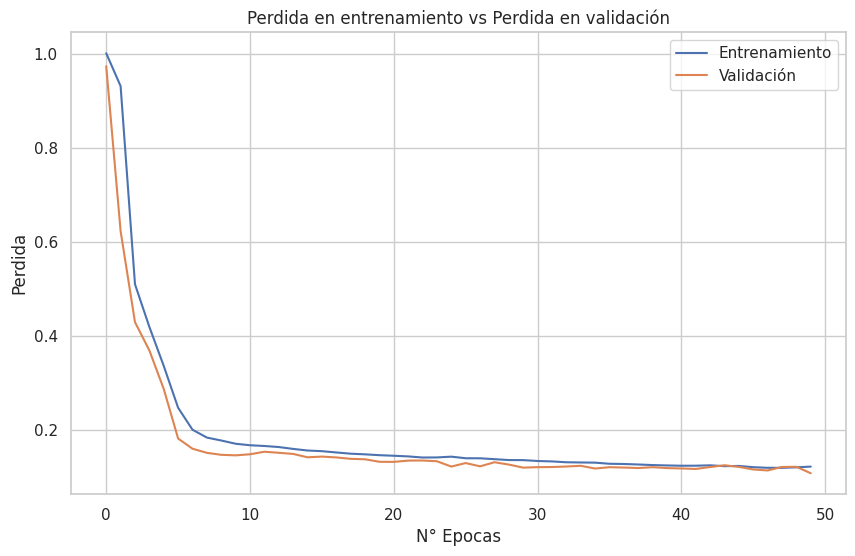

In [17]:
train_loss = history.history['loss']

val_loss = history.history['val_loss']

def plot_train_val(A, B, n, xlabel, ylabel, title):
    plt.figure(1, figsize=(10, 6))
    plt.plot(range(n),A)
    plt.plot(range(n),B)
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend(['Entrenamiento', 'Validación'])
    plt.show()

plot_train_val(train_loss, val_loss, ep, 'Perdida', 'N° Epocas', 'Perdida en entrenamiento vs Perdida en validación')

### Carga de modelo

In [9]:
model = load_model("Multi-Output-CNN", custom_objects=ak.CUSTOM_OBJECTS)

In [10]:
architecture = model.summary()
print(architecture)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 201, 1)]          0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 201, 1)           0         
 t32)                                                            
                                                                 
 expand_last_dim (ExpandLast  (None, 201, 1, 1)        0         
 Dim)                                                            
                                                                 
 conv2d (Conv2D)             (None, 201, 1, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 201, 1, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 101, 1, 32)       0     

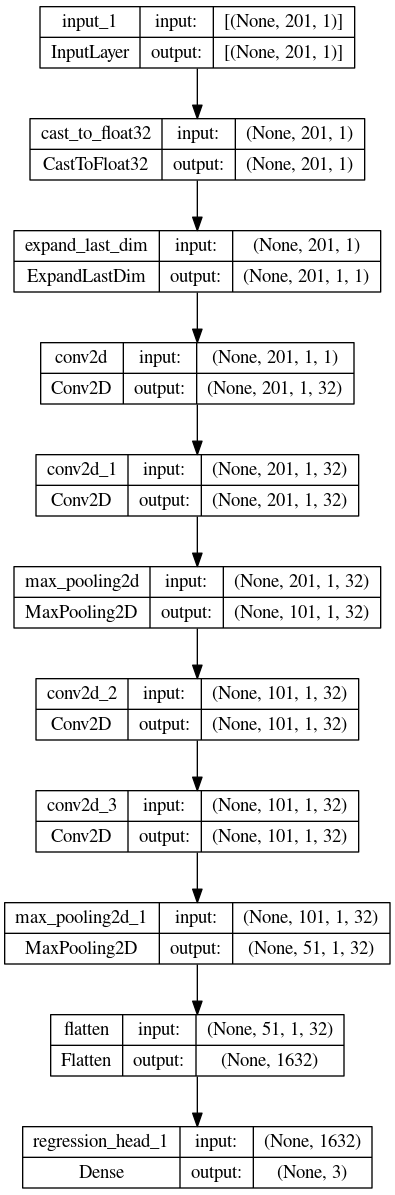

In [11]:
from tensorflow.keras.utils import plot_model

# Representación gráfica del modelo
plot_model(model, to_file='Multi-Output-CNN.png', show_shapes=True)

In [12]:
y_pred = model.predict(X_test_reshaped)

17/17 [==============================] - 0s 2ms/step


from sklearn.metrics import mean_absolute_error

(543,)
(543,)


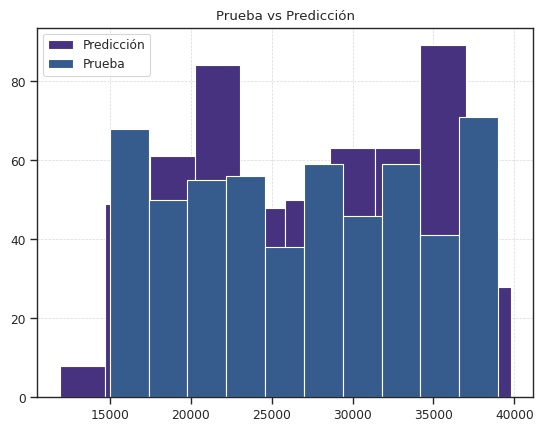

In [13]:
y_multirf = scaler.inverse_transform(y_pred)
print(y_multirf[:,0].shape)

y_val_inv=scaler.inverse_transform(y_val)

y_test = scaler.inverse_transform(y_test)
print(y_test[:,0].shape)

# Configuración de estilo
sns.set(style="ticks", context="paper", font_scale=1, palette='viridis')

plt.figure()
plt.title("Prueba vs Predicción")
plt.hist(y_multirf[:,0], label="Predicción")
plt.hist(y_test[:,0], label="Prueba")

plt.legend(loc="best")
plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.5)
plt.grid(alpha=0.3, linestyle='--')
plt.show()

In [14]:
#model.shape

In [15]:
y_multirf.shape

(543, 3)

# FASE 3 - EVALUACIÓN

## Métricas para medir error en la predicción

$$  MAE = \frac{\displaystyle\sum_{i=1}^{N} | t_i - \widehat{t_i}|}{N} $$

In [16]:
# Media de las diferencias absolutas entre los valores reales (y_test) y los valores predichos (y_multirf)

def MAE(y_test, y_multirf):
    return (np.mean(np.abs(y_test - y_multirf)))

$$ \begin{equation}
MARD = \frac{\displaystyle\sum_{i=1}^{N} \frac{| t_i - \widehat{t_i}|}{t_i }}{N}\times100
\end{equation}$$

In [17]:
def MARD(y_test, y_multirf):
    return (np.mean(np.abs(y_test - y_multirf)/y_test))*100

$$ MRD =\frac{\displaystyle\sum_{i=1}^{N}  t_i - \widehat{t_i}}{N} $$

In [18]:
def MRD(y_test, y_multirf):
    return (np.mean(y_test - y_multirf))

In [19]:
# Diccionario con los resultados de MAE, MARD y MRD 

resultados_metricas = {
    'Variable': ['Teff', 'Log(g)', 'Vroot'],
    'MAE': [MAE(y_test[:,0], y_multirf[:,0]), MAE(y_test[:,1], y_multirf[:,1]), MAE(y_test[:,2], y_multirf[:,2])],
    'MARD': [MARD(y_test[:,0], y_multirf[:,0]), MARD(y_test[:,1], y_multirf[:,1]), MARD(y_test[:,2], y_multirf[:,2])],
    'MRD': [MRD(y_test[:,0], y_multirf[:,0]), MRD(y_test[:,1], y_multirf[:,1]), MRD(y_test[:,2], y_multirf[:,2])]
}

df_resultados_metricas = pd.DataFrame(resultados_metricas)

print("Resultados de la predicción")
df_resultados_metricas

Resultados de la predicción


Variable          MAE       MARD        MRD
0     Teff  1589.798240   6.452183 -95.909252
1   Log(g)     0.382486  12.638917  -0.006644
2    Vroot     7.275515   3.778589  -1.317083



# Representaciones gráficas

### Temperatura Efectiva (Teff)

In [20]:
# Configuración de estilo
sns.set(style="ticks", context="paper", font_scale=1, palette='viridis')

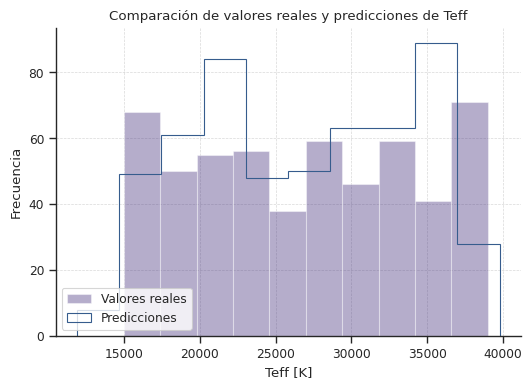

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))
# Histogramas
ax.hist(y_test[:,0], alpha=0.4, label="Valores reales")
ax.hist(y_multirf[:,0], label="Predicciones", histtype='step')

# Detalles del gráfico
ax.set_xlabel('Teff [K]')
ax.set_ylabel('Frecuencia')
ax.set_title('Comparación de valores reales y predicciones de Teff')
ax.legend(loc="lower left")
ax.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.5)
sns.despine()

# Mostrar el gráfico
plt.grid(alpha=0.3, linestyle='--')
plt.show()

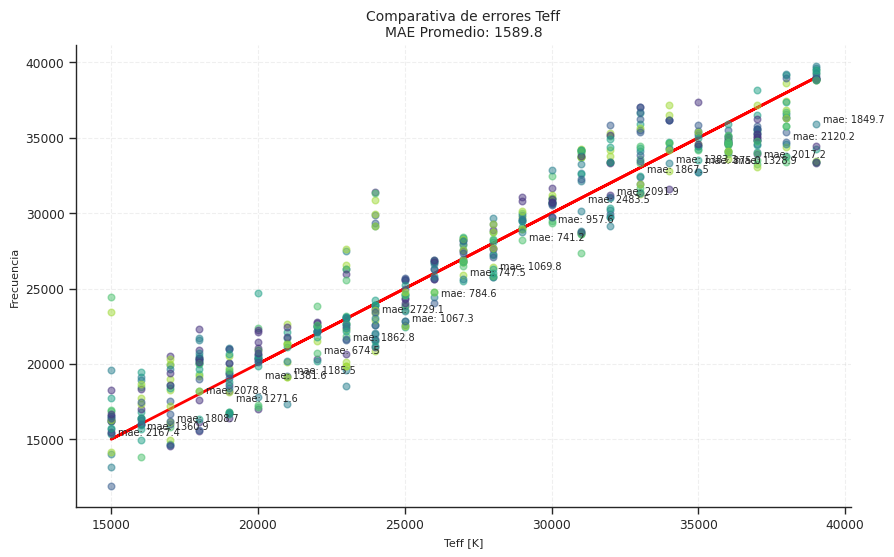

In [22]:
# Obtener valores únicos de la temperatura
temperaturas_unicas = np.unique(y_test[:,0])

# Promedio de MAE para cada temperatura
maes_promedio = []
for temperatura in temperaturas_unicas:
    indice = np.where(y_test[:,0] == temperatura)[0]
    mae_temp = np.mean(np.abs(y_test[indice,0] - y_multirf[indice,0]))
    maes_promedio.append(mae_temp)

# Calcular el MAE total
mae_total = MAE(y_test[:,0], y_multirf[:,0])

# Crear la figura
figura, ax = plt.subplots(figsize=(10, 6))

# Gráfico de puntos con barras de error
for i in range(len(y_test[:,0])):
    ax.errorbar(y_test[i,0], y_multirf[i,0], fmt='o', alpha=0.5, label="Predicciones")

# Agregar el MAE promedio para cada temperatura al gráfico
for i, temperatura in enumerate(temperaturas_unicas):
    indice = np.where(y_test[:,0] == temperatura)[0]
    x = np.mean(y_test[indice,0])
    y = np.mean(y_multirf[indice,0])
    ax.annotate('mae: {:.1f}'.format(maes_promedio[i]), xy=(x, y), xytext=(5, -15), textcoords='offset points', fontsize=7)

ax.plot(y_test[:,0], y_test[:,0], color='red', linewidth='2.0', linestyle='-', label="Valores reales")

# Detalles del gráfico
ax.set_xlabel('Teff [K]', fontsize=8)
ax.set_ylabel('Frecuencia', fontsize=8)
ax.set_title('Comparativa de errores Teff\nMAE Promedio: {:.1f}'.format(mae_total), fontsize=10)
#ejes.legend(loc="best", fontsize=8)
sns.despine()

# Mostrar el gráfico
plt.grid(alpha=0.3, linestyle='--')
plt.show()

### Gravedad superficial (log g)

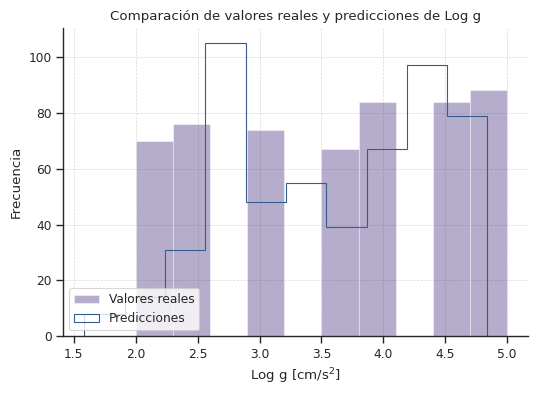

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))
# Histogramas
ax.hist(y_test[:,1], alpha=0.4, label="Valores reales")
ax.hist(y_multirf[:,1], label="Predicciones", histtype='step')

# Detalles del gráfico
ax.set_xlabel('Log g [cm/s$^2$]')
ax.set_ylabel('Frecuencia')
ax.set_title('Comparación de valores reales y predicciones de Log g')
ax.legend(loc="lower left")
ax.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.5)
sns.despine()

# Mostrar el gráfico
plt.grid(alpha=0.3, linestyle='--')
plt.show()

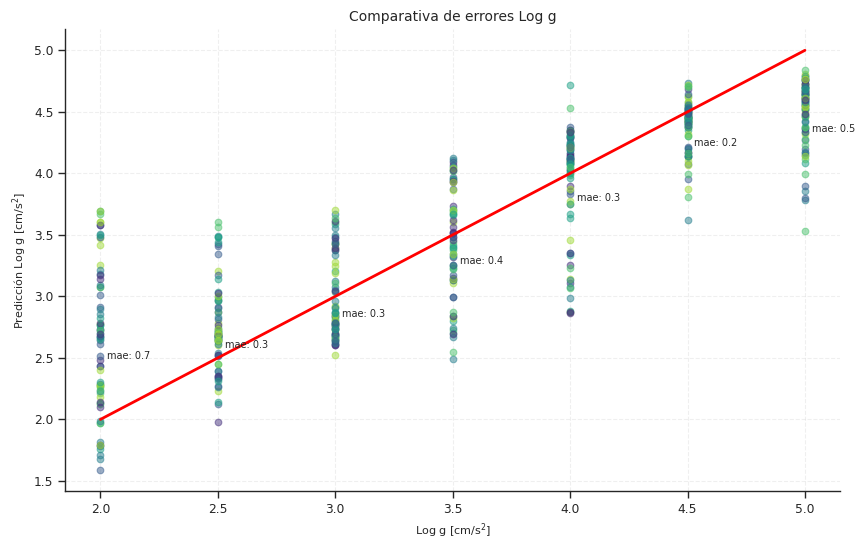

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as MAE

# Obtener valores únicos de la logg
logg_unico = np.unique(y_test[:, 1])

# Promedio de MAE para cada logg
maes_promedio = []
for logg in logg_unico:
    indice = np.where(y_test[:, 1] == logg)[0]  
    mae_temp = np.mean(np.abs(y_test[indice, 1] - y_multirf[indice, 1]))
    maes_promedio.append(mae_temp)

# Calcular el MAE total
mae_total = MAE(y_test[:, 1], y_multirf[:, 1])  

# Crear la figura
figura, ax = plt.subplots(figsize=(10, 6))

# Gráfico de puntos con barras de error
for i in range(len(y_test[:, 1])):
    ax.scatter(y_test[i, 1], y_multirf[i, 1], alpha=0.5)  

# Agregar el MAE promedio para cada logg al gráfico
for i, logg in enumerate(logg_unico):
    indice = np.where(y_test[:, 1] == logg)[0]  
    x = np.mean(y_test[indice, 1])
    y = np.mean(y_multirf[indice, 1])
    ax.annotate('mae: {:.1f}'.format(maes_promedio[i]), xy=(x, y), xytext=(5, -15), textcoords='offset points', fontsize=7)

ax.plot(y_test[:, 1], y_test[:, 1], color='red', linewidth='2.0', linestyle='-', label="Valores reales")

# Detalles del gráfico
ax.set_xlabel('Log g [cm/s$^2$]', fontsize=8)
ax.set_ylabel('Predicción Log g [cm/s$^2$]', fontsize=8)
ax.set_title('Comparativa de errores Log g', fontsize=10)

sns.despine()

# Mostrar el gráfico
plt.grid(alpha=0.3, linestyle='--')
plt.show()


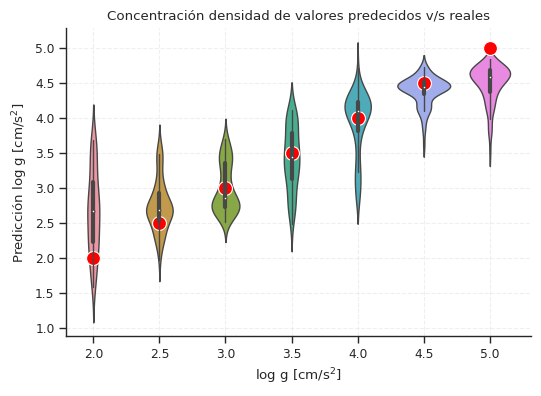

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))
# Gráfico de violín
sns.violinplot(x=y_test[:,1], y=y_multirf[:,1], linewidth=1, ax=ax)
sns.scatterplot(data=np.unique(y_test[:,1]), color='red', s=100, marker="o", ax=ax)

# Detalles del gráfico
ax.set_title('Concentración densidad de valores predecidos v/s reales')
ax.set_xlabel('log g [cm/s$^2$]')
ax.set_ylabel('Predicción log g [cm/s$^2$]')
sns.despine()

# Mostrar el gráfico
plt.grid(alpha=0.3, linestyle='--')
plt.show()

### Velocidad de rotación (Vroot)

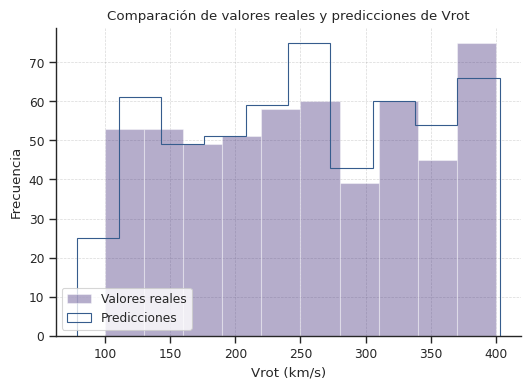

In [26]:
fig, ax = plt.subplots(figsize=(6, 4))
# Histogramas
ax.hist(y_test[:,2], alpha=0.4, label="Valores reales")
ax.hist(y_multirf[:,2], label="Predicciones", histtype='step')

# Detalles del gráfico
ax.set_xlabel('Vrot (km/s)')
ax.set_ylabel('Frecuencia')
ax.set_title('Comparación de valores reales y predicciones de Vrot')
ax.legend(loc="lower left")
ax.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.5)
sns.despine()

# Mostrar el gráfico
plt.grid(alpha=0.3, linestyle='--')
plt.show()

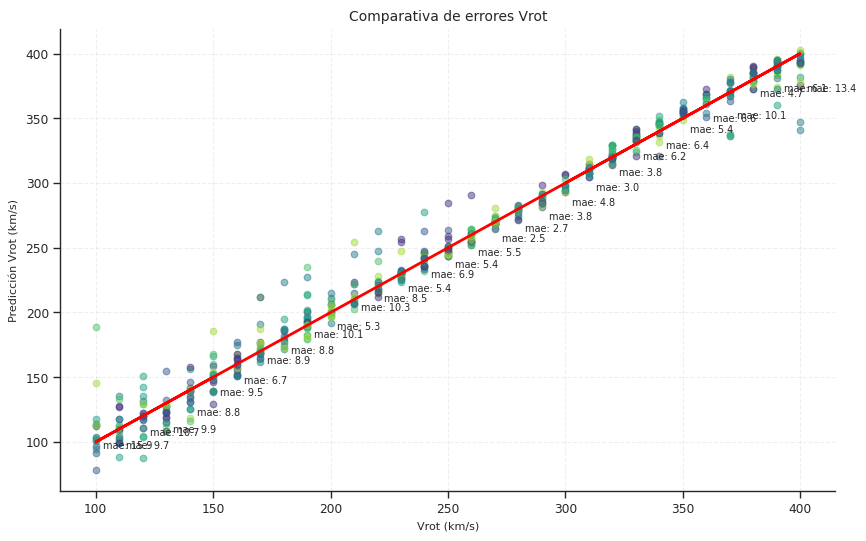

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as MAE

# Obtener valores únicos de la vrot
vrot_unico = np.unique(y_test[:, 2])

# Promedio de MAE para cada vrot
maes_promedio = []
for logg in vrot_unico:
    indice = np.where(y_test[:, 2] == logg)[0]  
    mae_temp = np.mean(np.abs(y_test[indice, 2] - y_multirf[indice, 2]))
    maes_promedio.append(mae_temp)

# Calcular el MAE total
mae_total = MAE(y_test[:, 2], y_multirf[:, 2]) 

# Crear la figura
figura, ax = plt.subplots(figsize=(10, 6))

# Gráfico de puntos con barras de error
for i in range(len(y_test[:, 2])):
    ax.scatter(y_test[i, 2], y_multirf[i, 2], alpha=0.5)  

# Agregar el MAE promedio para cada vrot al gráfico
for i, logg in enumerate(vrot_unico):
    indice = np.where(y_test[:, 2] == logg)[0]  
    x = np.mean(y_test[indice, 2])
    y = np.mean(y_multirf[indice, 2])
    ax.annotate('mae: {:.1f}'.format(maes_promedio[i]), xy=(x, y), xytext=(5, -15), textcoords='offset points', fontsize=7)

ax.plot(y_test[:, 2], y_test[:, 2], color='red', linewidth='2.0', linestyle='-', label="Valores reales")

# Detalles del gráfico
ax.set_xlabel('Vrot (km/s)', fontsize=8)
ax.set_ylabel('Predicción Vrot (km/s)', fontsize=8)
ax.set_title('Comparativa de errores Vrot', fontsize=10)

sns.despine()

# Mostrar el gráfico
plt.grid(alpha=0.3, linestyle='--')
plt.show()


# FASE 4 - Experimentos

Archivos del conjunto de Validación:
        Nombre de archivo
0    f_t15000g20v140.dat
1    f_t15000g20v370.dat
2    f_t15000g25v130.dat
3    f_t15000g25v160.dat
4    f_t15000g25v310.dat
..                   ...
538  f_t39000g40v210.dat
539  f_t39000g40v400.dat
540  f_t39000g45v250.dat
541  f_t39000g45v310.dat
542  f_t39000g50v100.dat

[543 rows x 1 columns]
Archivos del conjunto de Validación seleccionados:
 ['f_t15000g20v370.dat', 'f_t20000g25v210.dat', 'f_t25000g30v380.dat', 'f_t30000g35v140.dat', 'f_t35000g40v220.dat', 'f_t39000g50v100.dat']
1/1 [==============================] - 0s 17ms/step
Predicción a la línea con ruido
Teff: 18088.0
Log(g): 2.4
Vrot: 382.0


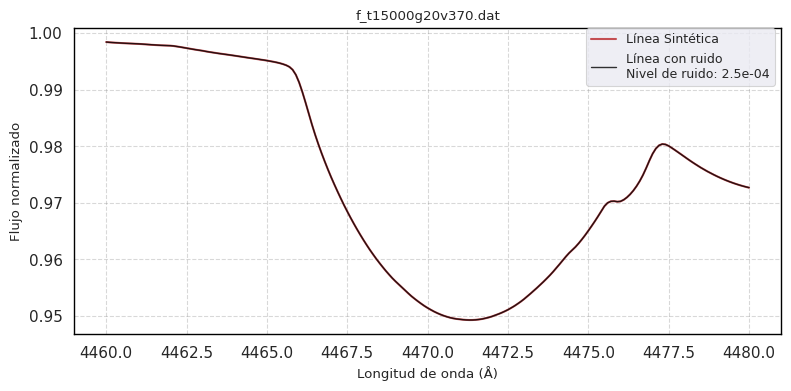

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 18091.1
Log(g): 2.4
Vrot: 382.0


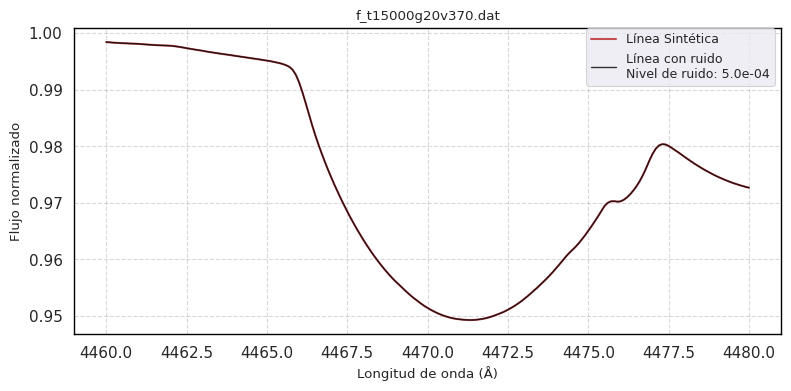

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 18104.2
Log(g): 2.4
Vrot: 382.0


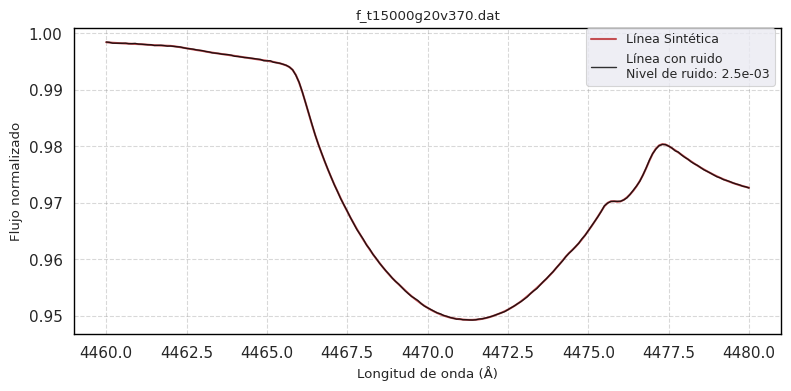

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 18119.2
Log(g): 2.4
Vrot: 381.9


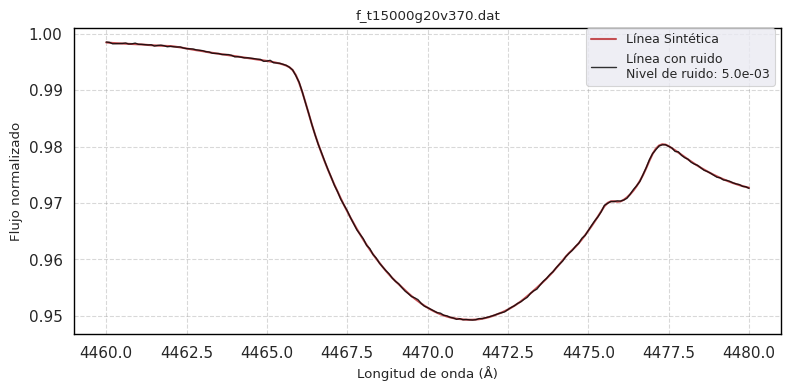

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 18234.4
Log(g): 2.4
Vrot: 381.6


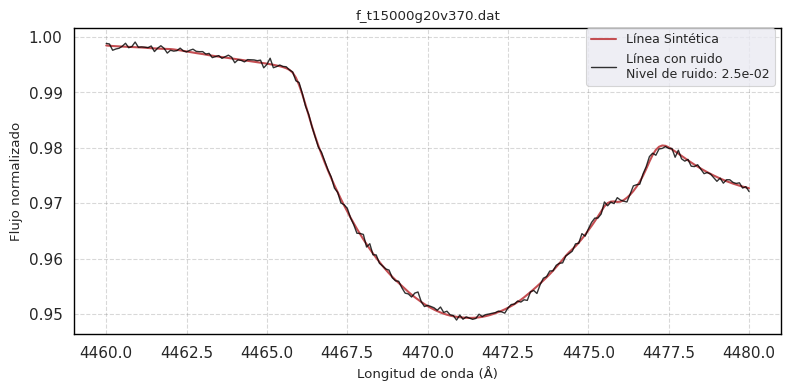

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 18180.1
Log(g): 2.4
Vrot: 382.9


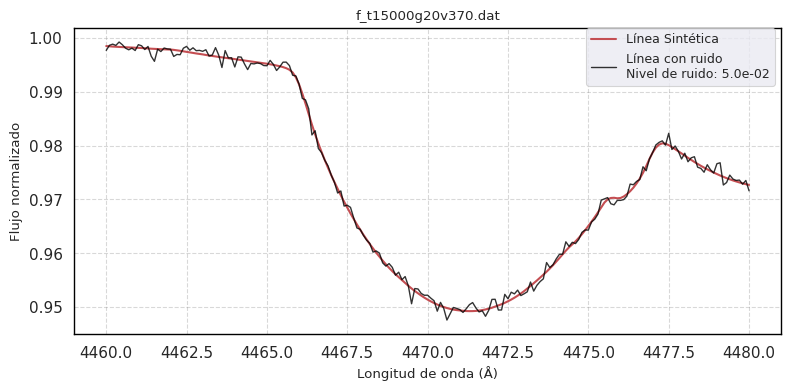

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 18398.7
Log(g): 2.4
Vrot: 388.1


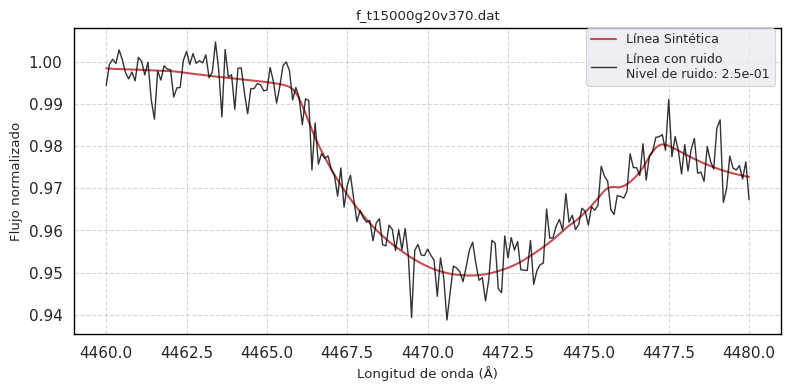

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 18661.4
Log(g): 2.4
Vrot: 391.6


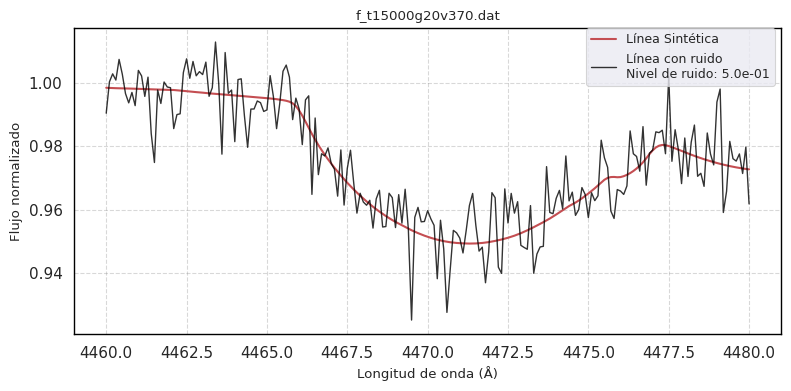

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 17358.0
Log(g): 2.0
Vrot: 212.4


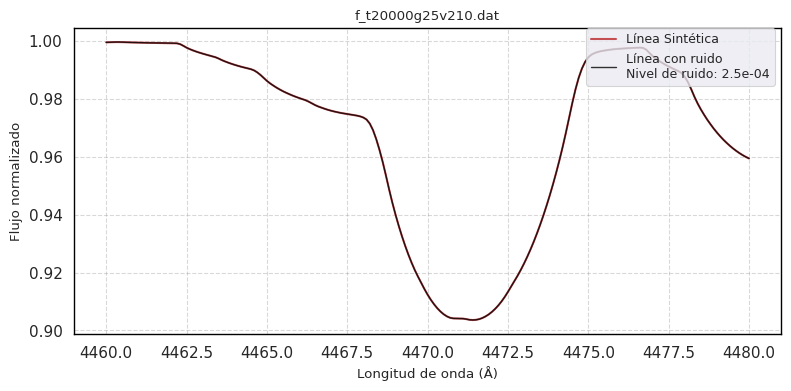

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 17356.6
Log(g): 2.0
Vrot: 212.4


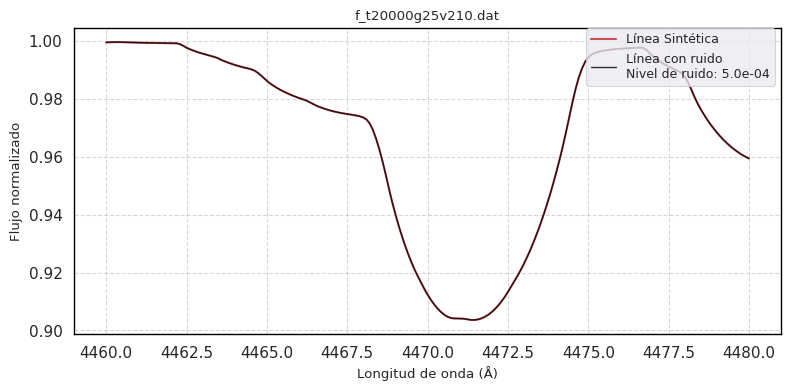

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 17344.9
Log(g): 2.0
Vrot: 212.4


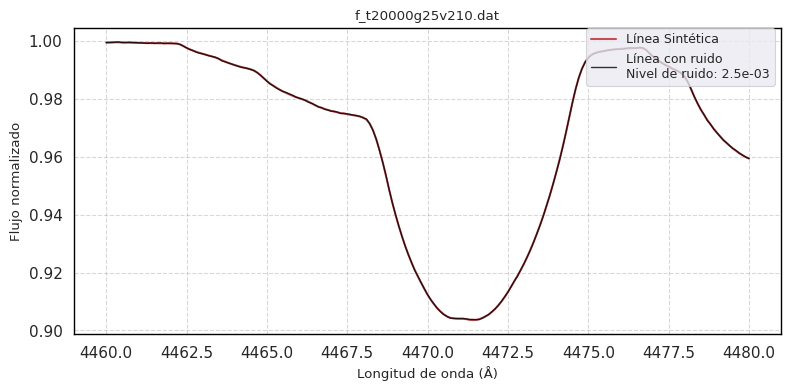

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 17327.8
Log(g): 2.0
Vrot: 212.5


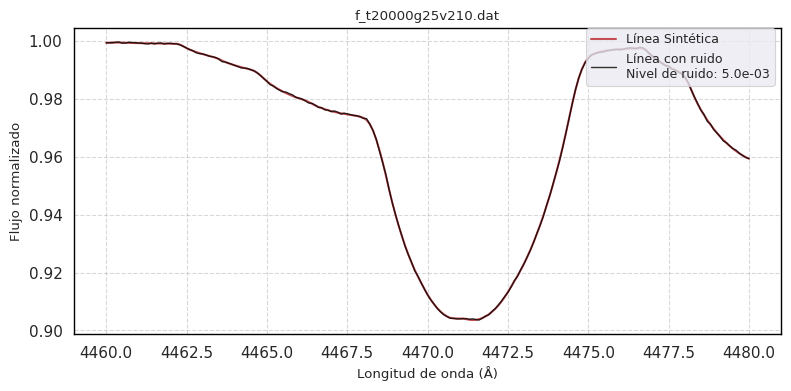

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 17246.1
Log(g): 2.0
Vrot: 210.7


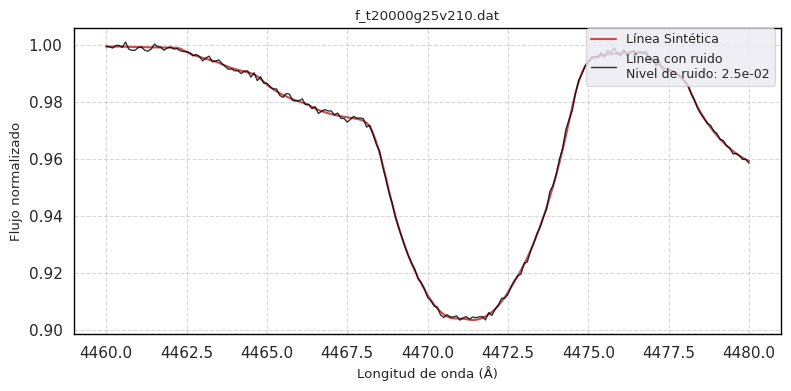

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 17125.6
Log(g): 2.0
Vrot: 208.9


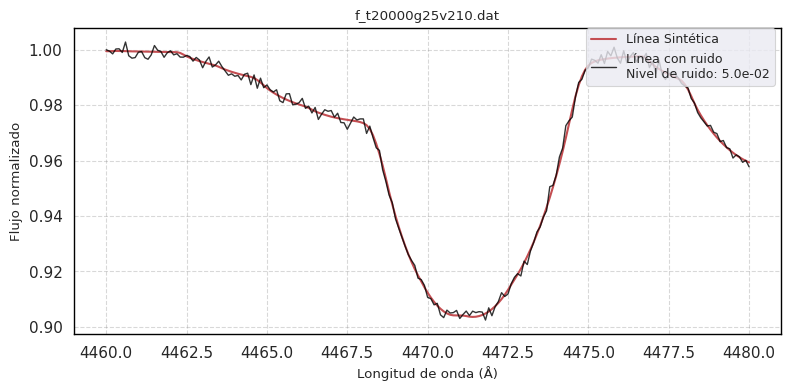

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 16256.7
Log(g): 1.8
Vrot: 192.2


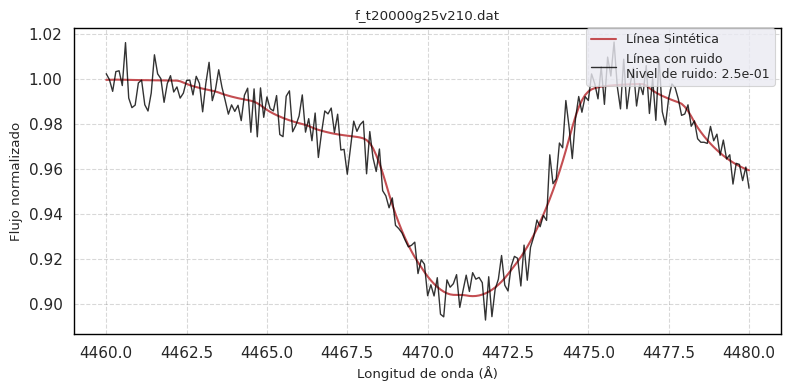

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 22418.0
Log(g): 2.1
Vrot: 196.6


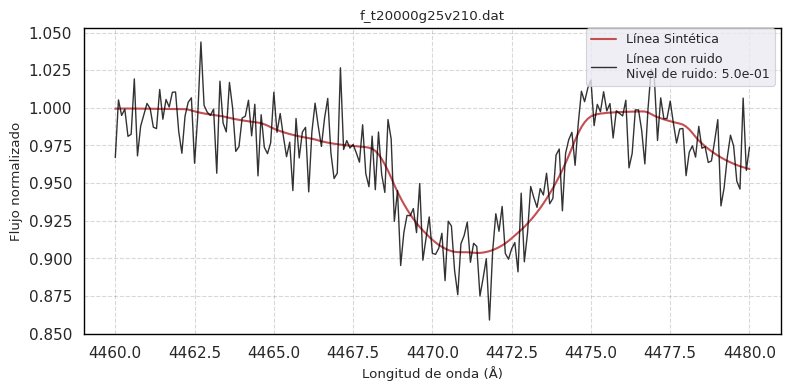

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 25171.3
Log(g): 2.9
Vrot: 370.3


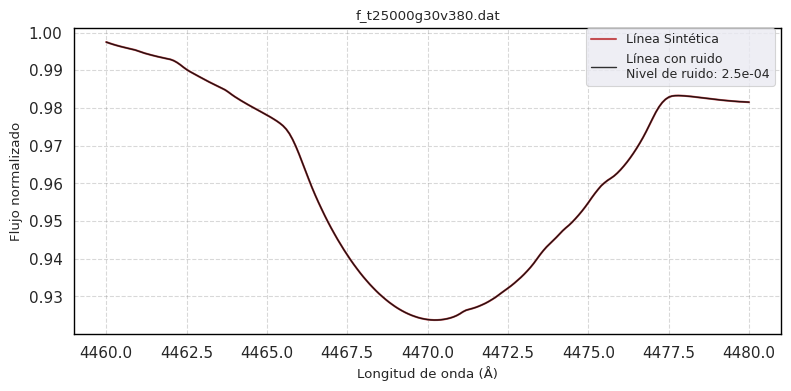

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 25173.2
Log(g): 2.9
Vrot: 370.3


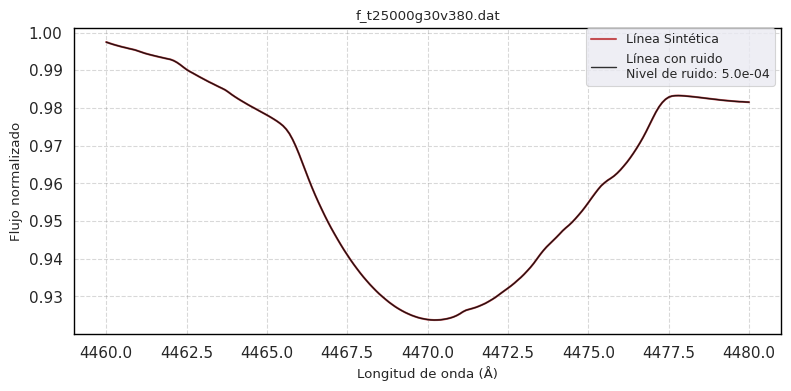

1/1 [==============================] - 0s 15ms/step
Predicción a la línea con ruido
Teff: 25187.5
Log(g): 2.9
Vrot: 370.4


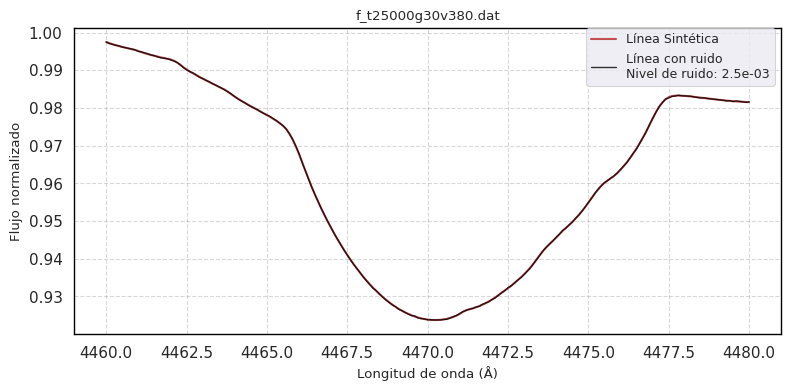

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 25205.7
Log(g): 2.9
Vrot: 370.4


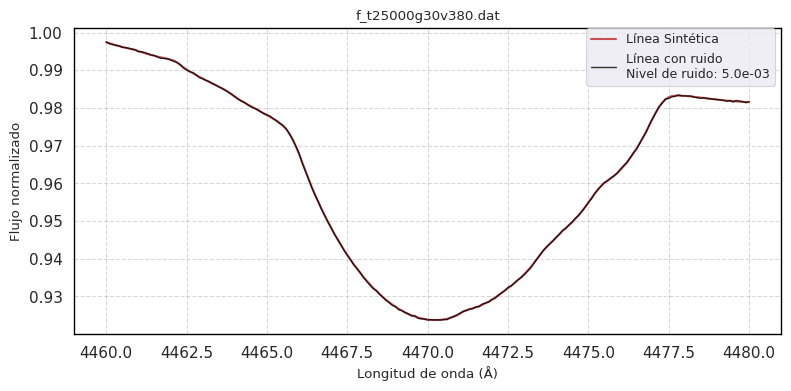

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 25354.8
Log(g): 2.9
Vrot: 370.7


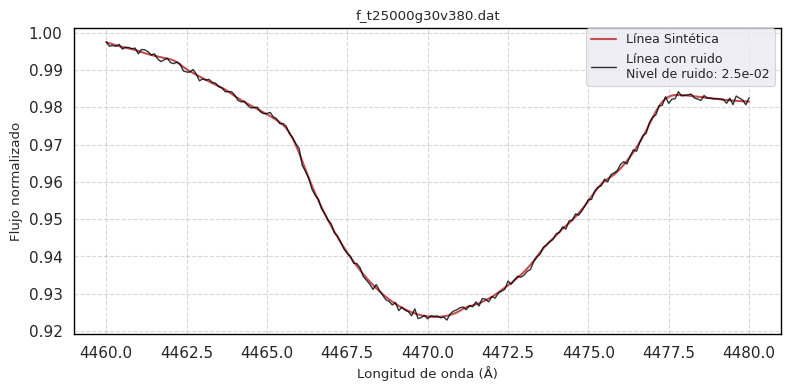

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 25544.2
Log(g): 2.9
Vrot: 371.0


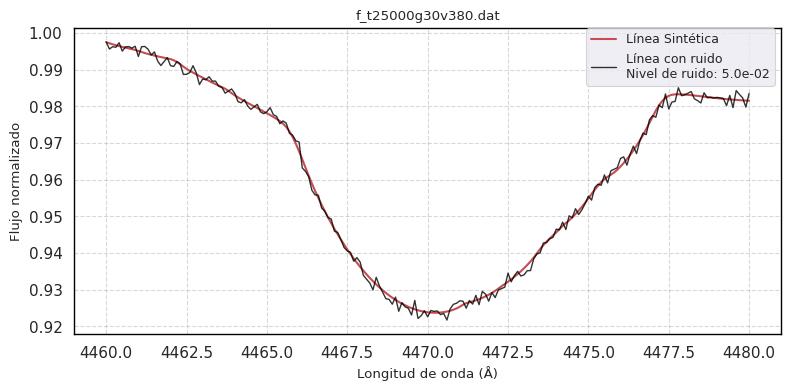

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 25895.3
Log(g): 2.9
Vrot: 382.3


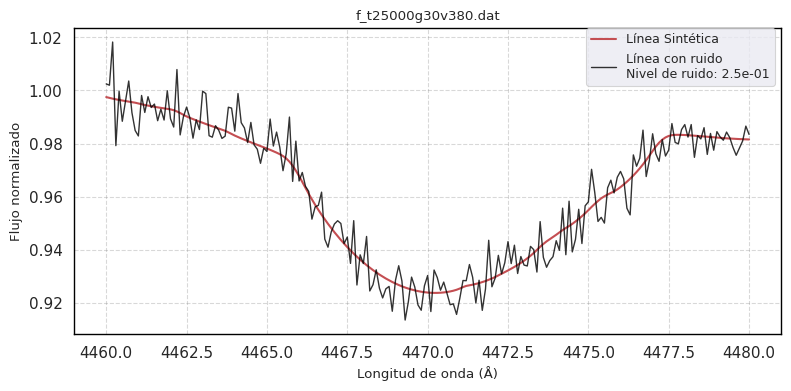

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 26452.6
Log(g): 3.0
Vrot: 395.2


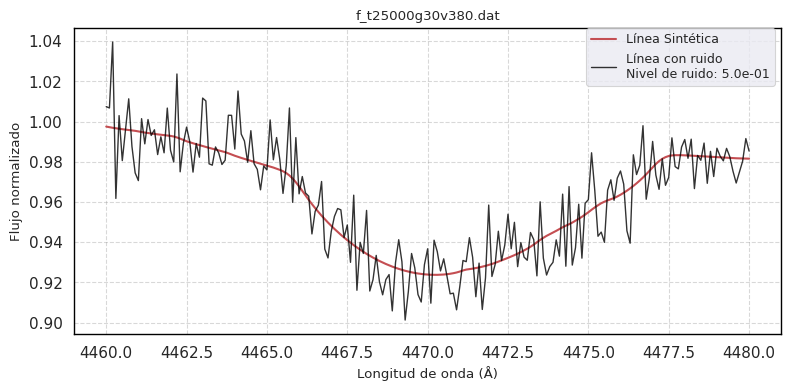

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 29434.3
Log(g): 3.4
Vrot: 134.5


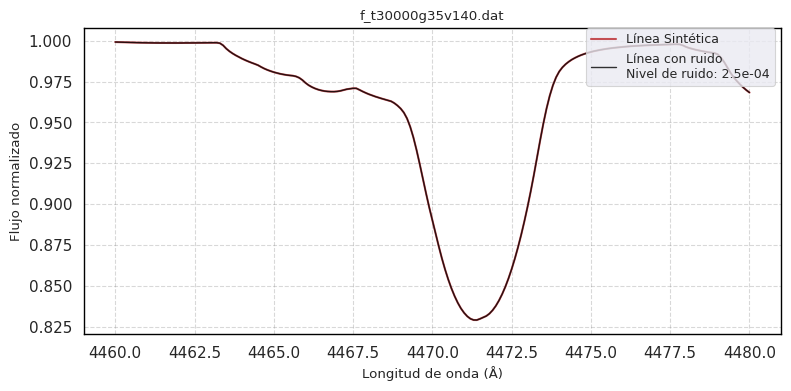

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 29446.9
Log(g): 3.4
Vrot: 134.5


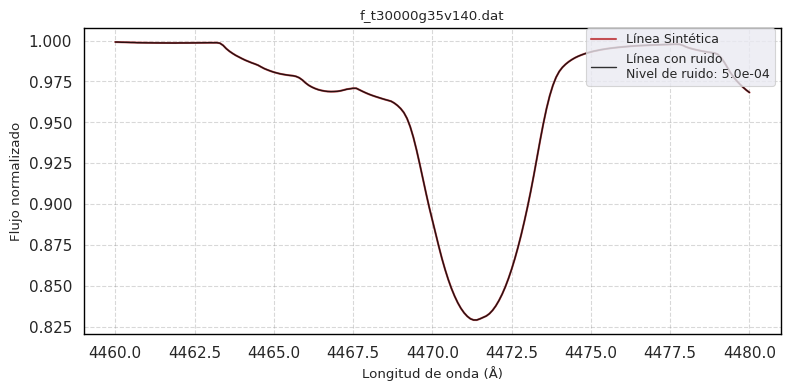

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 29500.3
Log(g): 3.4
Vrot: 134.6


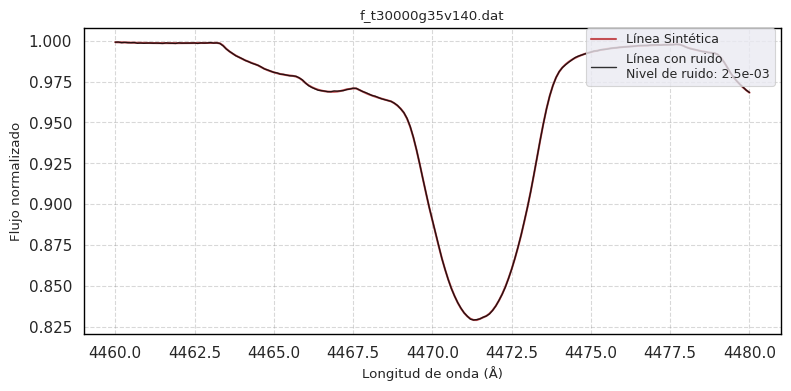

1/1 [==============================] - 0s 15ms/step
Predicción a la línea con ruido
Teff: 29565.8
Log(g): 3.4
Vrot: 134.7


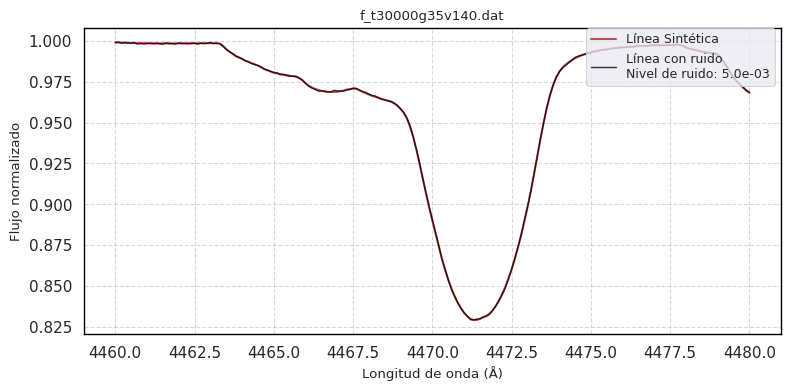

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 30072.5
Log(g): 3.5
Vrot: 135.9


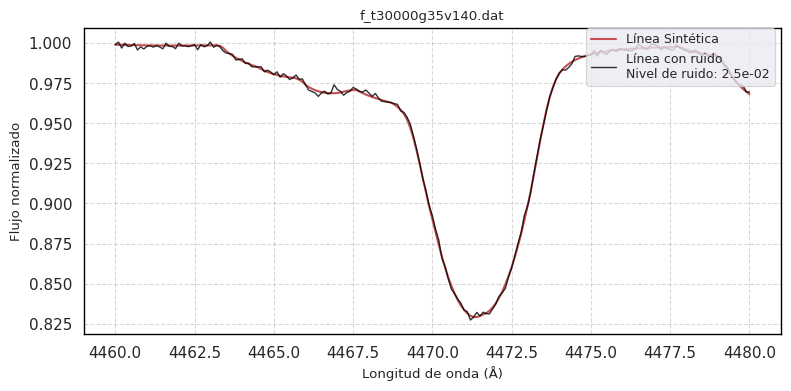

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 29226.2
Log(g): 3.4
Vrot: 131.9


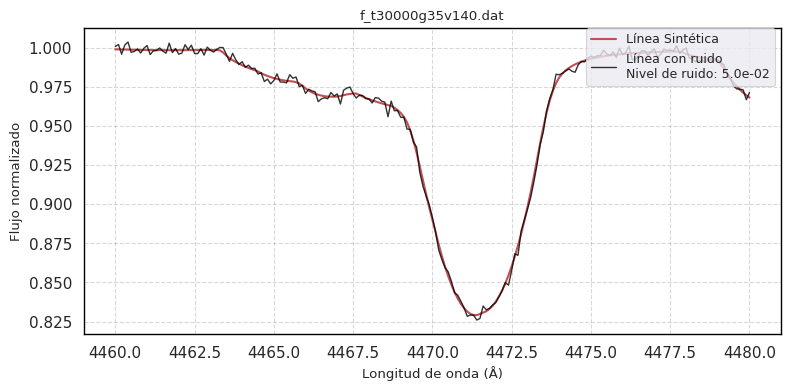

1/1 [==============================] - 0s 15ms/step
Predicción a la línea con ruido
Teff: 28717.5
Log(g): 3.5
Vrot: 121.5


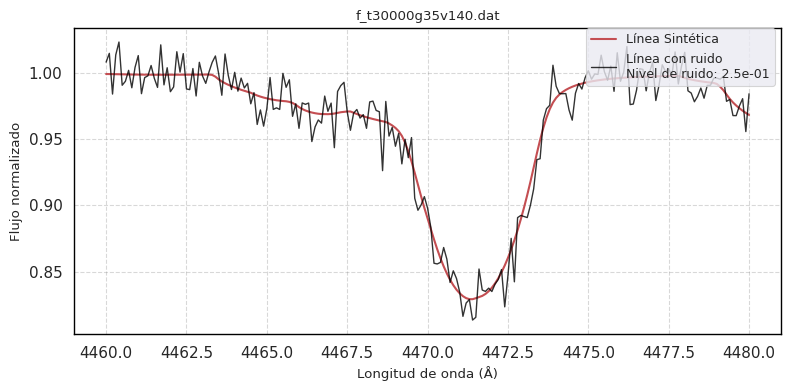

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 27699.4
Log(g): 3.5
Vrot: 111.1


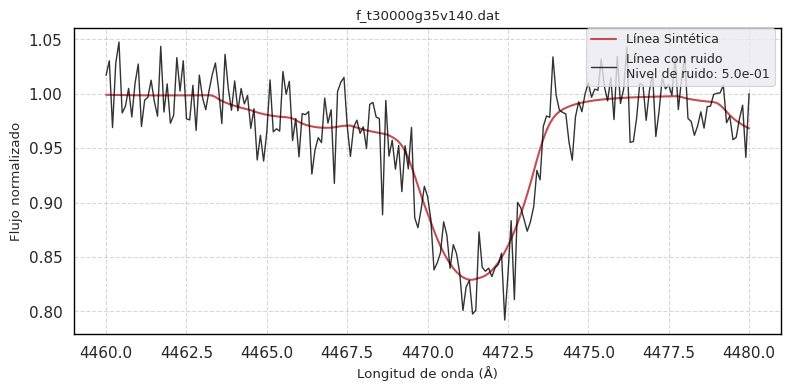

1/1 [==============================] - 0s 15ms/step
Predicción a la línea con ruido
Teff: 35629.6
Log(g): 3.8
Vrot: 220.7


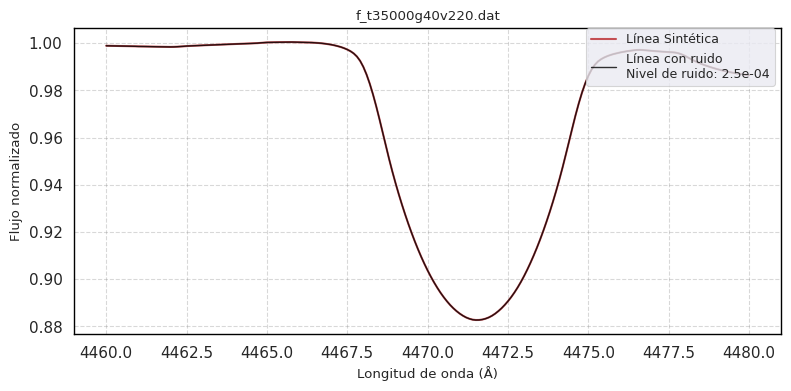

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 35629.2
Log(g): 3.8
Vrot: 220.7


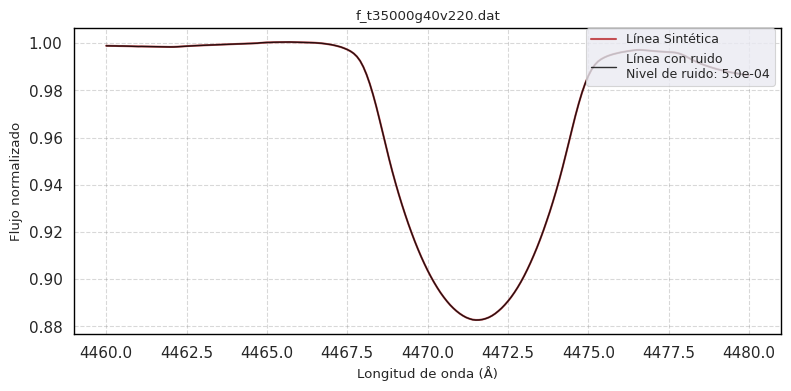

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 35624.5
Log(g): 3.8
Vrot: 220.8


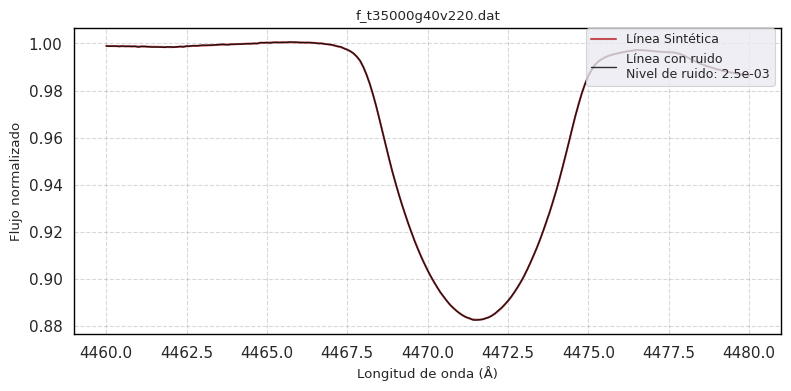

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 35613.4
Log(g): 3.8
Vrot: 221.0


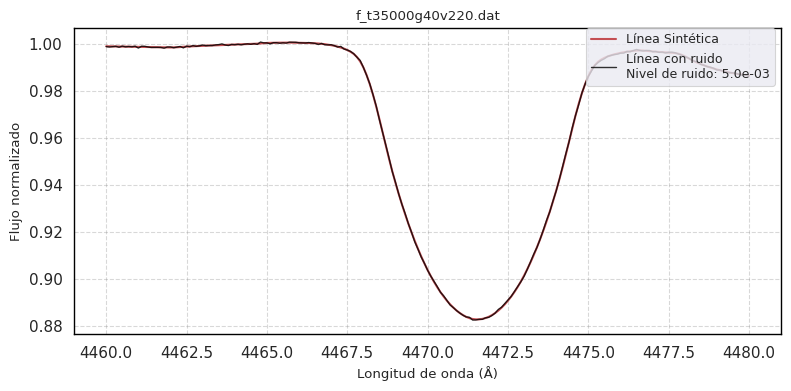

1/1 [==============================] - 0s 19ms/step
Predicción a la línea con ruido
Teff: 36048.9
Log(g): 3.8
Vrot: 222.2


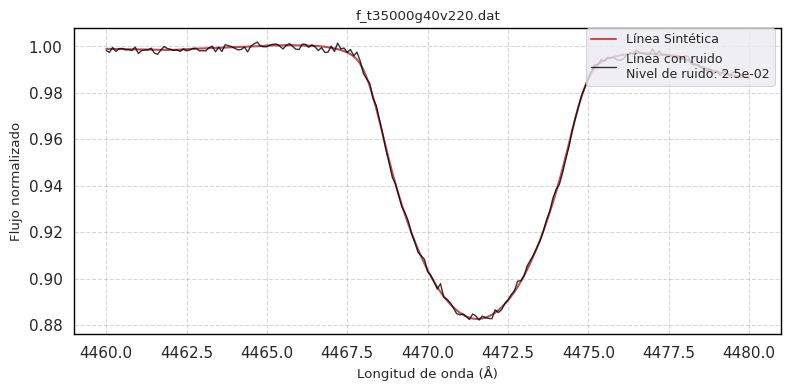

1/1 [==============================] - 0s 18ms/step
Predicción a la línea con ruido
Teff: 36493.3
Log(g): 3.8
Vrot: 223.4


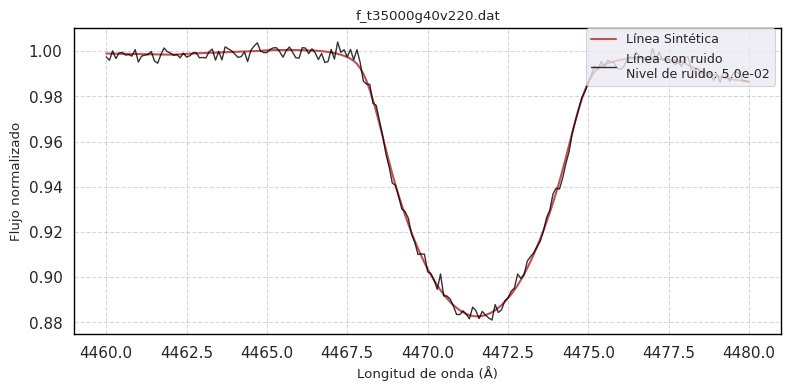

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 41140.2
Log(g): 4.0
Vrot: 229.4


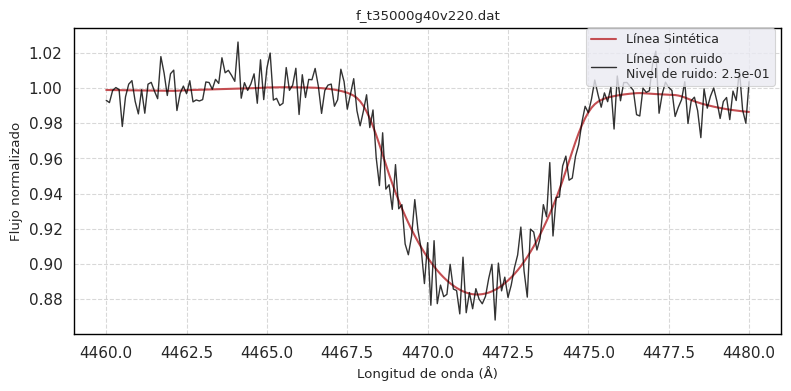

1/1 [==============================] - 0s 19ms/step
Predicción a la línea con ruido
Teff: 45771.5
Log(g): 4.2
Vrot: 237.9


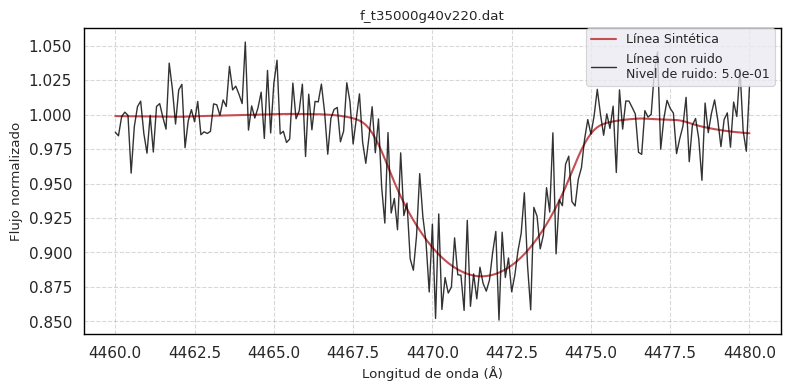

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 34980.2
Log(g): 3.6
Vrot: 114.9


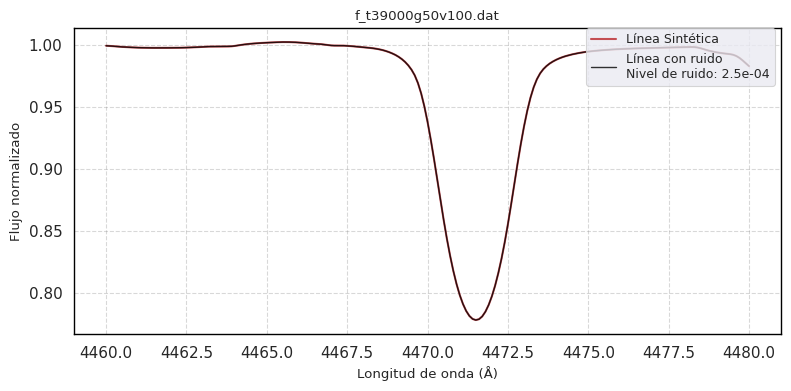

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 34968.7
Log(g): 3.6
Vrot: 115.0


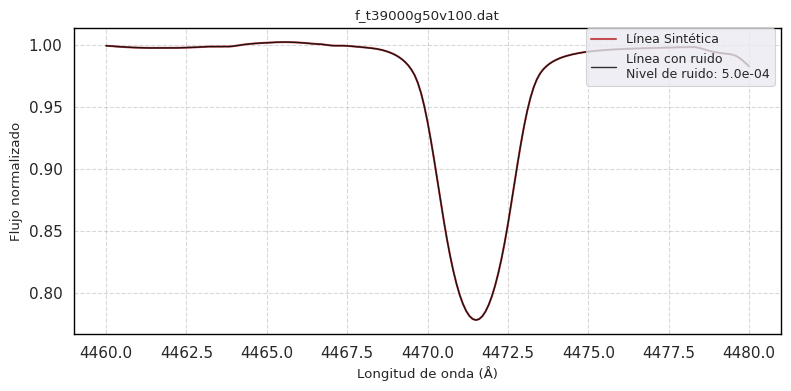

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 34950.9
Log(g): 3.6
Vrot: 115.3


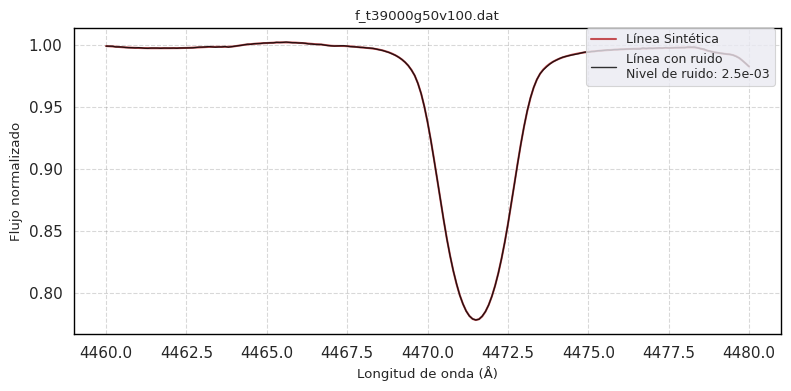

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 34928.6
Log(g): 3.6
Vrot: 115.7


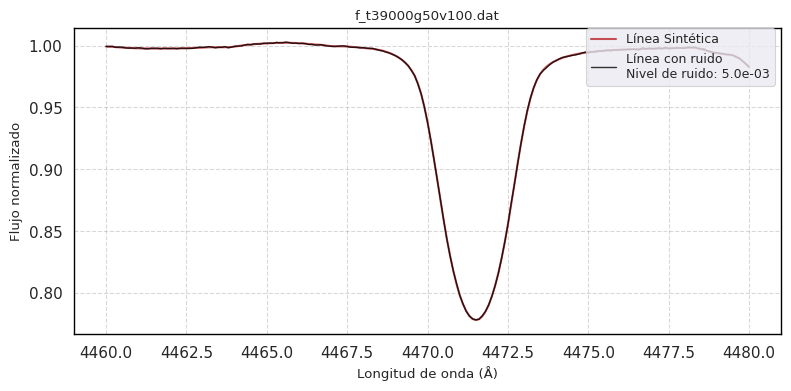

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 34749.1
Log(g): 3.6
Vrot: 118.6


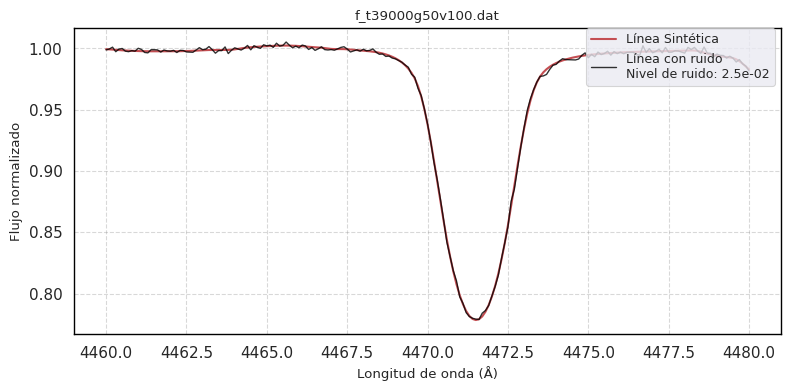

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 36153.9
Log(g): 3.6
Vrot: 114.9


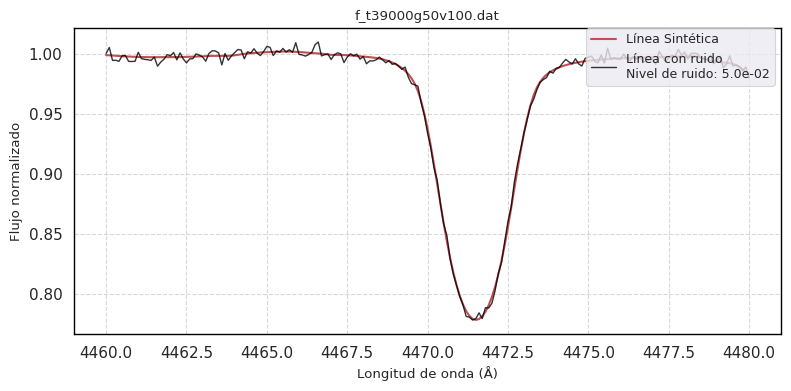

1/1 [==============================] - 0s 16ms/step
Predicción a la línea con ruido
Teff: 40560.4
Log(g): 3.6
Vrot: 114.1


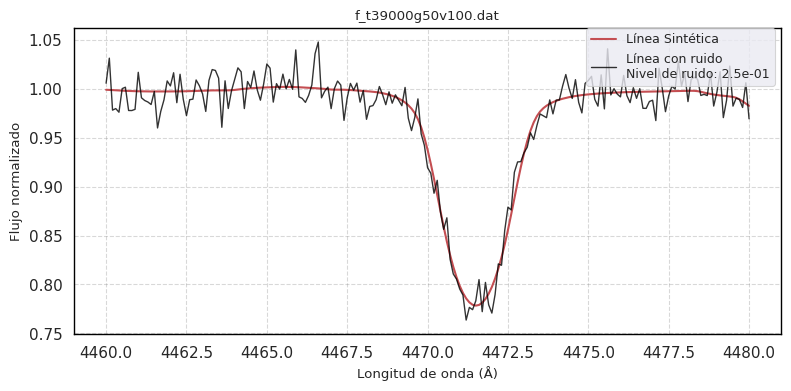

1/1 [==============================] - 0s 20ms/step
Predicción a la línea con ruido
Teff: 46126.5
Log(g): 3.7
Vrot: 124.2


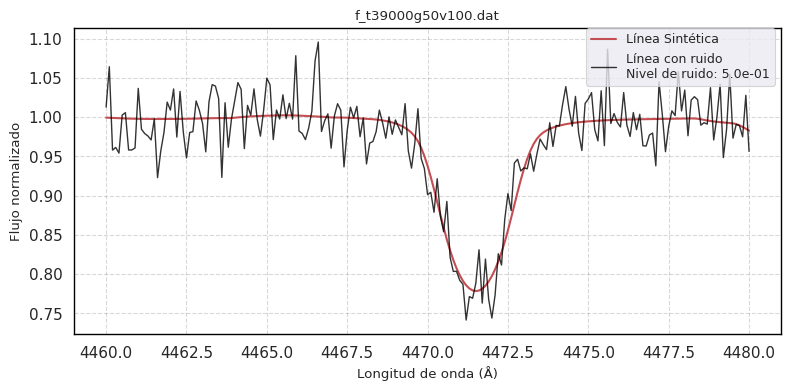

Ruido      Teff Prediccion_Teff Error_Teff Log_g Prediccion_Logg   
0   0.00e+00  15000.00        18087.98      20.59  2.00            2.42  \
1   0.00e+00  15000.00        18091.12      20.61  2.00            2.42   
2   0.00e+00  15000.00        18104.21      20.69  2.00            2.42   
3   1.00e-02  15000.00        18119.24      20.79  2.00            2.42   
4   3.00e-02  15000.00        18234.43      21.56  2.00            2.42   
5   5.00e-02  15000.00        18180.12      21.20  2.00            2.42   
6   2.50e-01  15000.00        18398.69      22.66  2.00            2.42   
7   5.00e-01  15000.00        18661.40      24.41  2.00            2.42   
8   0.00e+00  20000.00        17358.03      13.21  2.50            1.98   
9   0.00e+00  20000.00        17356.59      13.22  2.50            1.98   
10  0.00e+00  20000.00        17344.94      13.28  2.50            1.98   
11  1.00e-02  20000.00        17327.84      13.36  2.50            1.98   
12  3.00e-02  20000.00        17246.12      13.77  2.50            1.97   
13  5.00e-02  20000.00        17125.59      14.37  2.50            1.96   
14  2.50e-01  20000.00        16256.68      18.72  2.50            1.84   
15  5.00e-01  20000.00        22417.96      12.09  2.50            2.05   
16  0.00e+00  25000.00        25171.29       0.69  3.00            2.85   
17  0.00e+00  25000.00        25173.18       0.69  3.00            2.85   
18  0.00e+00  25000.00        25187.50       0.75  3.00            2.85   
19  1.00e-02  25000.00        25205.74       0.82  3.00            2.85   
20  3.00e-02  25000.00        25354.76       1.42  3.00            2.86   
21  5.00e-02  25000.00        25544.24       2.18  3.00            2.86   
22  2.50e-01  25000.00        25895.33       3.58  3.00            2.92   
23  5.00e-01  25000.00        26452.62       5.81  3.00            2.99   
24  0.00e+00  30000.00        29434.34       1.89  3.50            3.43   
25  0.00e+00  30000.00        29446.89       1.84  3.50            3.43   
26  0.00e+00  30000.00        29500.26       1.67  3.50            3.44   
27  1.00e-02  30000.00        29565.79       1.45  3.50            3.44   
28  3.00e-02  30000.00        30072.54       0.24  3.50            3.46   
29  5.00e-02  30000.00        29226.25       2.58  3.50            3.45   
30  2.50e-01  30000.00        28717.55       4.27  3.50            3.49   
31  5.00e-01  30000.00        27699.38       7.67  3.50            3.48   
32  0.00e+00  35000.00        35629.56       1.80  4.00            3.82   
33  0.00e+00  35000.00        35629.22       1.80  4.00            3.82   
34  0.00e+00  35000.00        35624.51       1.78  4.00            3.82   
35  1.00e-02  35000.00        35613.41       1.75  4.00            3.82   
36  3.00e-02  35000.00        36048.95       3.00  4.00            3.83   
37  5.00e-02  35000.00        36493.26       4.27  4.00            3.83   
38  2.50e-01  35000.00        41140.17      17.54  4.00            4.02   
39  5.00e-01  35000.00        45771.51      30.78  4.00            4.16   
40  0.00e+00  39000.00        34980.19      10.31  5.00            3.58   
41  0.00e+00  39000.00        34968.65      10.34  5.00            3.58   
42  0.00e+00  39000.00        34950.90      10.38  5.00            3.58   
43  1.00e-02  39000.00        34928.58      10.44  5.00            3.58   
44  3.00e-02  39000.00        34749.06      10.90  5.00            3.60   
45  5.00e-02  39000.00        36153.95       7.30  5.00            3.60   
46  2.50e-01  39000.00        40560.35       4.00  5.00            3.65   
47  5.00e-01  39000.00        46126.51      18.27  5.00            3.66   

   Error_Log_g    Vrot Prediccion_Vrot Error_Vrot  
0        20.98  370.00          382.01       3.25  
1        20.98  370.00          382.00       3.24  
2        21.00  370.00          381.96       3.23  
3        21.02  370.00          381.92       3.22  
4        21.20  370.00          381.61       3.14  
5        20.97  370

In [38]:
def obtener_archivos():
    nombres_archivos = []  # Lista para almacenar los nombres de los archivos encontrados

    # Ordenar las muestras por temperatura, logg y vrot de menor a mayor
    sorted_indices = np.lexsort((y_val_inv[:, 2], y_val_inv[:, 1], y_val_inv[:, 0]))
    sorted_muestras = y_val_inv[sorted_indices]

    for muestra in sorted_muestras:
        t_eff = muestra[0]
        logg = muestra[1]
        vrot = muestra[2]

        t_str = str(int(round(t_eff))).zfill(5)
        logg_str = str(int(round(logg * 10))).zfill(2)
        vrot_str = str(int(round(vrot))).zfill(3)
        nombre_archivo = f"f_t{t_str}g{logg_str}v{vrot_str}.dat"

        nombres_archivos.append(nombre_archivo)

    # Crear un DataFrame a partir de la lista de nombres de archivo
    df_archivos = pd.DataFrame({'Nombre de archivo': nombres_archivos})

    return df_archivos

def obtener_archivos_validacion():
    nombres_archivos = []  # Lista para almacenar los nombres de los archivos encontrados
    temperaturas = set()  # Conjunto para almacenar las temperaturas únicas

    for muestra in y_val_inv:
        t_eff = muestra[0]
        logg = muestra[1]
        vrot = muestra[2]

        t_str = str(int(round(t_eff))).zfill(5)
        logg_str = str(int(round(logg * 10))).zfill(2)
        vrot_str = str(int(round(vrot))).zfill(3)
        nombre_archivo = f"f_t{t_str}g{logg_str}v{vrot_str}.dat"

        # Verificar si el nombre del archivo cumple con los patrones específicos
        if (
            (t_str == '15000' and logg_str == '20' and vrot >= 100)
            or (t_str == '20000' and logg_str == '25' and vrot >= 100)
            or (t_str == '25000' and logg_str == '30' and vrot >= 100)
            or (t_str == '30000' and logg_str == '35' and vrot >= 100)
            or (t_str == '35000' and logg_str == '40' and vrot <= 400)
            or (t_str == '39000' and logg_str == '50' and vrot <= 400)
        ):
            if t_eff not in temperaturas:
                nombres_archivos.append(nombre_archivo)
                temperaturas.add(t_eff)
    nombres_archivos.sort()
    return nombres_archivos

def string2params(string, show=True):
    # Separamos la cadena en tres partes usando "g" y "v" como delimitadores
    s1 = string.partition("g")
    t = s1[0][1:] # Extraemos el valor de la temperatura a partir de la primera parte de la cadena
    s2 = s1[2].partition("v")
    g = s2[0] # Extraemos el valor de la gravedad superficial a partir de la segunda parte de la cadena
    v = s2[-1] # Extraemos el valor de la velocidad de rotación a partir de la tercera parte de la cadena
    return float(t), float(g)/10, float(v) # Devolvemos los valores de temperatura, gravedad superficial y velocidad de rotación en una tupla

def dif_porcentual(v_real, v_ruido):
    '''
    Entrega el % de error entre los valores reales y los ruidos
    utilizando la diferencia porcentual
    '''
    return abs(((v_ruido - v_real) / v_real) * 100)


# Configuración de gráficos
sns.set_style('ticks')
sns.set_palette('viridis')
sns.set_context('paper')

# Directorio de los modelos
carpeta_modelos = '../filtered_wv_models/'

# Niveles de ruido
niveles_ruido = [2.5e-4,5e-4,2.5e-3, 5e-3,2.5e-2, 5e-2,2.5e-1, 5e-1]

# Temperaturas de los modelos
teffs = [15000, 20000, 25000, 30000, 35000,39000]
# Crear listas vacías para almacenar los datos
temperaturas = []
niveles_de_ruido = []
temperaturas_ruidosas = []

flujos_ruidos = []

loggs = []
loggs_ruidosos = []
vrots = []
vrots_ruidosos = []

pred_teffs = []
pred_loggs = []
pred_vrots = []
errores_pred_teff = []
errores_pred_logg = []
errores_pred_vrot = []

print("Archivos del conjunto de Validación:\n", obtener_archivos())

print("Archivos del conjunto de Validación seleccionados:\n", obtener_archivos_validacion())
nombres_archivos= obtener_archivos_validacion()
for nombre_archivo in nombres_archivos:

    
    
    onda, flujo = np.loadtxt(carpeta_modelos + nombre_archivo, unpack=True)
    
    for i, nivel in enumerate(niveles_ruido):
        
        plt.figure(figsize=(8, 4))  # Nueva figura en cada iteración
        sns.set_style('dark', {'axes.edgecolor': 'black'})
        plt.title(nombre_archivo)
        #1D8ABD
        linea_sintetica, = plt.plot(onda, flujo, label="Línea Sintética", color='r', linewidth=1.5)
        
        
        hora = datetime.datetime.now()
        # Convertir la fecha y hora a un número entero (segundos desde la época)
        semilla = int(hora.timestamp())
        np.random.seed(semilla)  # Semilla aleatoria en cada iteración
        mu = 0
        sigma = nivel
 
        ruido = np.random.normal(mu, sigma * np.std(flujo), len(flujo))
        flujo_ruidoso = flujo + ruido

        flujos_ruidos.append(flujo_ruidoso)
        flujos_ruidos_array = np.array(flujo_ruidoso)
    
        t_real, logg_real, vrot_real = string2params(nombre_archivo.split("_")[-1].split(".")[0])


        #error_t_eff = dif_porcentual(t_real, t_real_ruido)
        linea_ruidosa, = plt.plot(onda, flujo_ruidoso, color='black',
                                  label=f"Línea con ruido\nNivel de ruido: {nivel:.1e}",
                                  alpha=0.8, linewidth=1)

        flujo_ruidoso_entrada = flujo_ruidoso.reshape(1, -1, 1)



        pred_obs = model.predict(flujo_ruidoso_entrada)
        pred_obs_inv = scaler.inverse_transform(pred_obs) #desnormalizacion prediccion
        
        print("Predicción a la línea con ruido")
        teff_predict= pred_obs_inv[0,0]
        logg_predict=pred_obs_inv[0,1]
        vrot_predict=pred_obs_inv[0,2]
        
        print(f"Teff: {teff_predict:.1f}")
        print(f"Log(g): {logg_predict:.1f}")
        print(f"Vrot: {vrot_predict:.1f}")

        # Guardar las predicciones en las listas
        pred_teffs.append(pred_obs_inv[0, 0])
        pred_loggs.append(pred_obs_inv[0, 1])
        pred_vrots.append(pred_obs_inv[0, 2])
        
        # Calcular el error entre la temperatura sin ruido y las predicciones
        error_pred_t_eff = dif_porcentual(t_real, pred_obs_inv[0, 0])
        error_pred_logg = dif_porcentual(logg_real, pred_obs_inv[0, 1])
        error_pred_vrot = dif_porcentual(vrot_real, pred_obs_inv[0, 2])
        
        # Guardar el error en la lista de errores
        errores_pred_teff.append(error_pred_t_eff)
        errores_pred_logg.append(error_pred_logg)
        errores_pred_vrot.append(error_pred_vrot)
        
        # Guardar los datos en las listas
        temperaturas.append(t_real)
        niveles_de_ruido.append(nivel)
        #temperaturas_ruidosas.append(t_real_ruido)
        
        loggs.append(logg_real)
        #loggs_ruidosos.append(logg_real_ruido)
        vrots.append(vrot_real)
        #vrots_ruidosos.append(vrot_real_ruido)
        

        plt.legend(bbox_to_anchor=(1.0, 1.02), loc='upper right', fontsize=9)

        # Agregar un marco negro
        plt.gca().set_facecolor('white')
        sns.set_style({'axes.edgecolor': 'black'})

        # Modificar el color y estilo de las líneas de la cuadrícula
        plt.grid(alpha=0.3, linestyle='--', color='gray')

        plt.xlabel('Longitud de onda (Å)')
        plt.ylabel('Flujo normalizado')
        plt.tick_params(axis='both', which='major', labelsize=11)
        plt.tight_layout()

        plt.show()

# Crear el dataframe
df_resultados = pd.DataFrame({
    'Ruido': niveles_de_ruido,
    'Teff': temperaturas,
    'Prediccion_Teff': pred_teffs, 
    'Error_Teff': errores_pred_teff,
    'Log_g': loggs,
    'Prediccion_Logg': pred_loggs, 
    'Error_Log_g': errores_pred_logg,
    'Vrot': vrots,
    'Prediccion_Vrot': pred_vrots, 
    'Error_Vrot': errores_pred_vrot
})

# Formatear todas las columnas a notación científica
for columna in df_resultados.columns:
    df_resultados[columna] = df_resultados[columna].apply(lambda x: '{:.2f}'.format(x))
    df_resultados["Ruido"] = df_resultados["Ruido"].apply(lambda x: '{:.2e}'.format(float(x)))

    
df_resultados


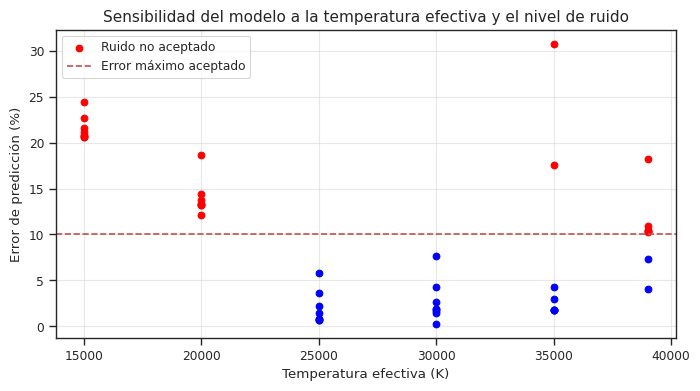

Teff Ruido_maximo_aceptado Ruido_no_aceptado
0  15000                     -           5.0e-01
1  20000                     -           5.0e-01
2  25000               5.0e-01                 -
3  30000               5.0e-01                 -
4  35000               5.0e-02           5.0e-01
5  39000               2.5e-01           5.0e-01

In [42]:
# Crear una figura y un objeto de ejes
fig, ax = plt.subplots(figsize=(8, 4))

# Configuración de gráficos
sns.set_style('ticks')
sns.set_palette(['blue', 'red'])
sns.set_context('paper')

# Crear un gráfico de dispersión con ruido en el eje Y y las temperaturas en el eje X
for i, teff in enumerate(teffs):
    errores_teff = errores_pred_teff[i * len(niveles_ruido):(i + 1) * len(niveles_ruido)]
    for j, error in enumerate(errores_teff):
        label = 'Ruido no aceptado' if i == 0 and j == 0 and error > 10 else ''
        label = 'Ruido aceptado' if i == 0 and j == 0 and error <= 10 else label
        if error > 10:
            ax.scatter(teff, error, color='red', label=label)
        else:
            ax.scatter(teff, error, color='blue', label=label)


ax.set_xlabel("Temperatura efectiva (K)")
ax.set_ylabel("Error de predicción (%)")

# Agregar una línea horizontal en el 10%
ax.axhline(y=10, color='r', linestyle='--', label='Error máximo aceptado')

# Calcular el ruido máximo permitido para cada temperatura y agregarlo al gráfico
ruido_maximo = []
for teff in teffs:
    errores_teff = df_resultados.loc[df_resultados['Teff'].astype(float) == teff, 'Error_Teff'].astype(float)
    ruido_teff = df_resultados.loc[df_resultados['Teff'].astype(float) == teff, 'Ruido'].astype(float)
    
    # Encuentra el ruido máximo antes de que el error supere el 10%
    ruido_max_teff = ruido_teff[errores_teff <= 10].max()
    ruido_maximo.append(ruido_max_teff)

# Agregar una leyenda
ax.legend()
# Agregar un título y modificar el tamaño de fuente de los ticks de los ejes
plt.title("Sensibilidad del modelo a la temperatura efectiva y el nivel de ruido", fontsize=11)
ax.tick_params(axis='both', which='major')

# Cambiar el color de la grilla a gris claro
ax.grid(color='lightgray', alpha=0.5)

# Ajustar la transparencia de la grilla
ax.grid(alpha=0.5)

plt.show()

# Mostrar el ruido máximo para cada temperatura en un DataFrame
ruido_maximo_formateado = [f"{r:.1e}" if pd.notnull(r) else '-' for r in ruido_maximo]
df_ruido_maximo = pd.DataFrame({'Teff': teffs, 'Ruido_maximo_aceptado': ruido_maximo_formateado})

# Calcular el ruido máximo no aceptado para cada temperatura y agregarlo al gráfico
ruido_no_aceptado = []
for teff in teffs:
    errores_teff = df_resultados.loc[df_resultados['Teff'].astype(float) == teff, 'Error_Teff'].astype(float)
    ruido_teff = df_resultados.loc[df_resultados['Teff'].astype(float) == teff, 'Ruido'].astype(float)
    
    # Encuentra el ruido máximo que produce un error superior al 10%
    ruido_no_aceptado_teff = ruido_teff[errores_teff > 10].max()
    ruido_no_aceptado.append(ruido_no_aceptado_teff)

# Agregar la lista de ruidos máximos no aceptados como una nueva columna al DataFrame
df_ruido_maximo["Ruido_no_aceptado"] = ruido_no_aceptado

# Formatear la columna "Ruido_no_aceptado" a notación científica con 1 decimal 
df_ruido_maximo["Ruido_no_aceptado"] = df_ruido_maximo["Ruido_no_aceptado"].apply(lambda x: "{:.1e}".format(x) if pd.notnull(x) else '-')

# Mostrar el DataFrame actualizado
df_ruido_maximo

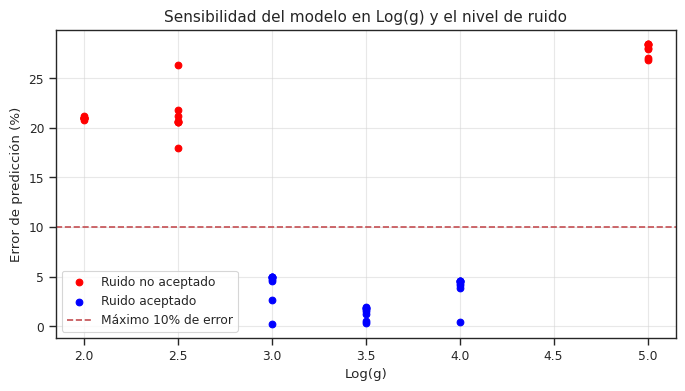

log Ruido_maximo Ruido_no_aceptado
0  2.0            -           5.0e-01
1  2.5            -           5.0e-01
2  3.0      5.0e-01                 -
3  3.5      5.0e-01                 -
4  4.0      5.0e-01                 -
5  5.0            -           5.0e-01

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Obtener las velocidades de rotación únicas
loggs = sorted(df_resultados['Log_g'].astype(float).unique())


# Crear una figura y un objeto de ejes
fig, ax = plt.subplots(figsize=(8, 4))

# Configuración de gráficos
sns.set_style('ticks')
sns.set_palette('viridis')
sns.set_context('paper')

label_added_red = False
label_added_blue = False

for i, log in enumerate(loggs):
    errores_log = errores_pred_logg[i * len(niveles_ruido):(i + 1) * len(niveles_ruido)]
    for j, error in enumerate(errores_log):
        if error > 10 and not label_added_red:  # Agregar el punto rojo y su label solo una vez
            ax.scatter(log, error, color='red', label='Ruido no aceptado')
            label_added_red = True  # Se agrega el punto rojo en la leyenda
        elif error <= 10 and not label_added_blue:  # Se agrega el punto  azul y su label solo una vez
            ax.scatter(log, error, color='blue', label='Ruido aceptado')
            label_added_blue = True 
        else: 
            if error > 10:
                ax.scatter(log, error, color='red')
            else:
                ax.scatter(log, error, color='blue')
            
ax.set_xlabel("Log(g)")
ax.set_ylabel("Error de predicción (%)")

# Agregar una línea horizontal en el 10%
maximo_error_aceptado = 10
ax.axhline(y=maximo_error_aceptado, color='r', linestyle='--', label='Máximo 10% de error')

# Calcular el ruido máximo permitido para cada Log(g) y agregarlo al gráfico
ruido_maximo = []
for log in loggs:
    errores_log = df_resultados.loc[df_resultados['Log_g'].astype(float) == log, 'Error_Log_g'].astype(float)
    ruido_log = df_resultados.loc[df_resultados['Log_g'].astype(float) == log, 'Ruido'].astype(float)
    
    # Encontrar el ruido máximo antes de que el error supere el 10%
    ruido_max_log = ruido_log[errores_log <= 10].max()
    ruido_maximo.append(ruido_max_log)

# Agregar una leyenda
ax.legend()

# Agregar un título y modificar el tamaño de fuente de los ticks de los ejes
plt.title("Sensibilidad del modelo en Log(g) y el nivel de ruido", fontsize=11)
ax.tick_params(axis='both', which='major')

# Cambiar el color de la grilla a gris claro y ajustar la transparencia
ax.grid(color='lightgray', alpha=0.5)

# Mostrar el gráfico
plt.show()

# Mostrar el ruido máximo para cada Log(g) en un DataFrame
ruido_maximo_formateado = [f"{r:.1e}" if pd.notnull(r) else '-' for r in ruido_maximo]
df_ruidos_log = pd.DataFrame({'log': loggs, 'Ruido_maximo': ruido_maximo_formateado})

# Calcular el ruido máximo no aceptado para cada Log(g) y agregarlo al DataFrame
ruido_no_aceptado = []
for log in loggs:
    errores_log = df_resultados.loc[df_resultados['Log_g'].astype(float) == log, 'Error_Log_g'].astype(float)
    ruido_log = df_resultados.loc[df_resultados['Log_g'].astype(float) == log, 'Ruido'].astype(float)
    
    # Encontrar el ruido máximo que produce un error superior al 10%
    ruido_no_aceptado_log = ruido_log[errores_log > 10].max()
    ruido_no_aceptado.append(ruido_no_aceptado_log)

# Agregar la lista como una nueva columna al DataFrame
df_ruidos_log["Ruido_no_aceptado"] = ruido_no_aceptado

# Modificar la columna "Ruido_no_aceptado" a notación científica con 1 decimal
df_ruidos_log["Ruido_no_aceptado"] = df_ruidos_log["Ruido_no_aceptado"].apply(lambda x: "{:.1e}".format(x) if pd.notnull(x) else '-')

# Ordenar el DataFrame por la columna 'log'
df_ruidos_log = df_ruidos_log.sort_values(by='log')

df_ruidos_log

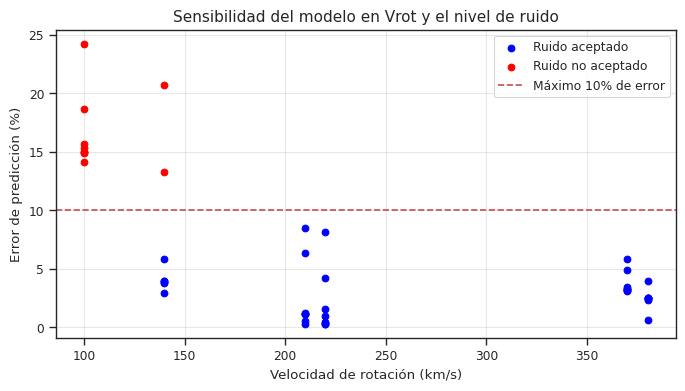

Vrot Ruido_maximo Ruido_no_aceptado
5  100.0            -           5.0e-01
3  140.0      5.0e-02           5.0e-01
1  210.0      5.0e-01                 -
4  220.0      5.0e-01                 -
0  370.0      5.0e-01                 -
2  380.0      5.0e-01                 -

In [41]:
# Obtener las velocidades de rotación únicas
vrots = df_resultados['Vrot'].astype(float).unique()

# Crear una figura y un objeto de ejes
fig, ax = plt.subplots(figsize=(8, 4))

# Configuración de gráficos
sns.set_style('ticks')
sns.set_palette('viridis')
sns.set_context('paper')

label_added_red = False
label_added_blue = False

for i, vrot in enumerate(vrots):
    errores_vrot = errores_pred_vrot[i * len(niveles_ruido):(i + 1) * len(niveles_ruido)]
    for j, error in enumerate(errores_vrot):
        if error > 10 and not label_added_red:  # Agregar el punto rojo y su label solo una vez
            ax.scatter(vrot, error, color='red', label='Ruido no aceptado')
            label_added_red = True  # Se agrega el punto rojo en la leyenda
        elif error <= 10 and not label_added_blue:  # Se agrega el punto  azul y su label solo una vez
            ax.scatter(vrot, error, color='blue', label='Ruido aceptado')
            label_added_blue = True 
        else: 
            if error > 10:
                ax.scatter(vrot, error, color='red')
            else:
                ax.scatter(vrot, error, color='blue')
                
ax.set_xlabel("Velocidad de rotación (km/s)")
ax.set_ylabel("Error de predicción (%)")

# Agregar una línea horizontal en el 10%
maximo_error_aceptado = 10
ax.axhline(y=maximo_error_aceptado, color='r', linestyle='--', label='Máximo 10% de error')

# Calcular el ruido máximo permitido para cada velocidad de rotación y agregarlo al gráfico
ruido_maximo = []
for vrot in vrots:
    errores_vrot = df_resultados.loc[df_resultados['Vrot'].astype(float) == vrot, 'Error_Vrot'].astype(float)
    ruido_vrot = df_resultados.loc[df_resultados['Vrot'].astype(float) == vrot, 'Ruido'].astype(float)
    
    # Encontrar el ruido máximo antes de que el error supere el 10%
    ruido_max_vrot = ruido_vrot[errores_vrot <= 10].max()
    ruido_maximo.append(ruido_max_vrot)

# Agregar una leyenda
ax.legend()

# Agregar un título y modificar el tamaño de fuente de los ticks de los ejes
plt.title("Sensibilidad del modelo en Vrot y el nivel de ruido", fontsize=11)
ax.tick_params(axis='both', which='major')

# Cambiar el color de la grilla a gris claro y ajustar la transparencia
ax.grid(color='lightgray', alpha=0.5)

# Mostrar el gráfico
plt.show()

# Mostrar el ruido máximo para cada velocidad de rotación en un DataFrame
ruido_maximo_formateado = [f"{r:.1e}" if pd.notnull(r) else '-' for r in ruido_maximo]
df_ruidos_vrot = pd.DataFrame({'Vrot': vrots, 'Ruido_maximo': ruido_maximo_formateado})

# Calcular el ruido máximo no aceptado para cada temperatura y agregarlo al gráfico
ruido_no_aceptado = []
for vrot in vrots:
    errores_vrot = df_resultados.loc[df_resultados['Vrot'].astype(float) == vrot, 'Error_Vrot'].astype(float)
    ruido_vrot = df_resultados.loc[df_resultados['Vrot'].astype(float) == vrot, 'Ruido'].astype(float)
    
    # Encontrar el ruido máximo que produce un error superior al 10%
    ruido_no_aceptado_vrot = ruido_vrot[errores_vrot > 10].max()
    ruido_no_aceptado.append(ruido_no_aceptado_vrot)

# Agregar la lista como una nueva columna al DataFrame
df_ruidos_vrot["Ruido_no_aceptado"] = ruido_no_aceptado

# Modificar la columna "Ruido_no_aceptado" a notación científica con 1 decimal
df_ruidos_vrot["Ruido_no_aceptado"] = df_ruidos_vrot["Ruido_no_aceptado"].apply(lambda x: "{:.1e}".format(x) if pd.notnull(x) else '-')

# Ordenar el DataFrame por la columna 'Vrot'
df_ruidos_vrot = df_ruidos_vrot.sort_values(by='Vrot')

df_ruidos_vrot
